In [1]:
# uncomment these to install dependencies
import sys
!{sys.executable} -m pip install matplotlib pandas seaborn pyyaml ua-parser user-agents crawlerdetect nginx-error-log randomcolor
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from pprint import pprint
from copy import deepcopy
import json
import re
import tarfile
from crawlerdetect import CrawlerDetect
crawler_detect = CrawlerDetect()
import randomcolor
rand_color = randomcolor.RandomColor()


access_logs_count = 15

logs_tarfile_name = 'logs.tar.xz'
if os.path.exists(os.path.join(os.getcwd(), logs_tarfile_name)):
    tar = tarfile.open(os.path.join(os.getcwd(), logs_tarfile_name), 'r:xz')
    tar.extractall()
    tar.close()


if not os.path.exists(os.path.join(os.getcwd(), 'logs.pkl')) or\
   not os.path.exists(os.path.join(os.getcwd(), 'logs_no_bots.pkl')) or\
   not os.path.exists(os.path.join(os.getcwd(), 'logs_only_bots.pkl')):

    access_logs = []

    for i in range(access_logs_count):
        extension = ('.' + str(i)) if i > 0 else ""
        filepath = os.path.join(os.getcwd(), "nginx_logs/access.log" + extension)
        try:
            log_df = pd.read_csv(filepath,
                        sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                        engine='python',
                        usecols=[0, 3, 4, 5, 6, 7, 8],
                        names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
                        na_values='-',
                        header=None
                          )
            access_logs.append(log_df)
        except FileNotFoundError:
            filepath = os.path.join(os.getcwd(), "nginx_logs/access.log" + extension + ".gz")
            log_df = pd.read_csv(filepath,
                        sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                        engine='python',
                        usecols=[0, 3, 4, 5, 6, 7, 8],
                        names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
                        na_values='-',
                        header=None
                          )
            access_logs.append(log_df)
        print('Reading', filepath)
    df = pd.concat(access_logs)
    df_nobots = df[df['user_agent'].apply(lambda ua:\
         ua == '"-"' or 'curl' in ua\
         or crawler_detect.isCrawler(ua)\
         if isinstance(ua, str) else True) == False]
    df_onlybots = df[df['user_agent'].apply(lambda ua:\
         ua == '"-"' or 'curl' in ua\
         or crawler_detect.isCrawler(ua)\
         if isinstance(ua, str) else True) == True]
    df.to_pickle(os.path.join(os.getcwd(), 'logs.pkl'))
    df_nobots.to_pickle(os.path.join(os.getcwd(), 'logs_no_bots.pkl'))
    df_onlybots.to_pickle(os.path.join(os.getcwd(), 'logs_only_bots.pkl'))
df = pd.read_pickle(os.path.join(os.getcwd(), 'logs.pkl'))
df_nobots = pd.read_pickle(os.path.join(os.getcwd(), 'logs_no_bots.pkl'))
df_onlybots = pd.read_pickle(os.path.join(os.getcwd(), 'logs_only_bots.pkl'))

human_and_bot_req_count = len(df)
human_req_count = len(df_nobots)
bot_req_count = len(df_onlybots)

print("Total number of requests (bots and humans):", len(df))
print("Total number of non-bot requests:", len(df_nobots))
print("Total number of bot requests:", len(df_onlybots))


def parse_endpoint(endpoint: str):
    endpoint = endpoint.strip().split('/')
    if len(endpoint) > 0 and endpoint[0] == '':
        endpoint = endpoint[1:] # remove empty string
    for i in range(len(endpoint)):
        if '?' in endpoint[i]: # remove query string
            endpoint[i] = endpoint[i][0:endpoint[i].index('?')]
    if (len(endpoint) > 1 and len(endpoint[1]) == 24):
        endpoint[1] = '{id}'
    if len(endpoint) == 4 and endpoint[2] == 'download':
        endpoint[3] = '{name}'
    if len(endpoint) == 4 and endpoint[2] == 'hashsum_file':
        endpoint[1] = '{id}'
        endpoint[3] = '{algo}'
    if (len(endpoint) >= 4) and endpoint[1] == 'hashsum':
        endpoint[2] = '{algo}'
        endpoint[3] = '{hash}'
    endpoint = '/'.join(endpoint)
    return endpoint

Total number of requests (bots and humans): 1389995
Total number of non-bot requests: 401013
Total number of bot requests: 988982


In [58]:

from nginx_error_log import parse_line, ParseError
import gzip

error_logs_count = 15

error_logs = {'cid': [], 'level': [], 'message': [], 'pid': [], 'tid': [], 'timestamp': []}

if not os.path.exists(os.path.join(os.getcwd(), 'error_logs.pkl')):
    for i in range(error_logs_count):
        extension = ('.' + str(i)) if i > 0 else ""
        filepath = os.path.join(os.getcwd(), "nginx_logs/error.log" + extension)
        try:
            file = open(filepath, 'r')
        except FileNotFoundError:
            file = gzip.open(filepath + '.gz', 'rt')
        lines = file.readlines()
        file.close()
        for index, line in enumerate(lines):
            try:
                parsed_line = parse_line(line)
                error_logs['cid'].append(parsed_line.cid)
                error_logs['level'].append(str(parsed_line.level))
                error_logs['message'].append(parsed_line.message)
                error_logs['pid'].append(parsed_line.pid)
                error_logs['tid'].append(parsed_line.tid)
                error_logs['timestamp'].append(parsed_line.timestamp)
            except ParseError:
                print("[{0}:{1}] Error parsing log, \"{2}\"".format(os.path.basename(filepath), index, line))
    # TODO: create another dataframe with bots filtered out
    errors_df = pd.DataFrame(data=error_logs)
    errors_df.to_pickle(os.path.join(os.getcwd(), 'error_logs.pkl'))

errors_df = pd.read_pickle(os.path.join(os.getcwd(), 'error_logs.pkl'))
print("Number of errors:", len(errors_df))


Number of errors: 69135


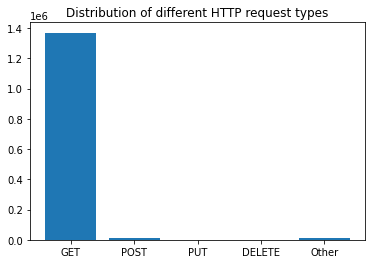

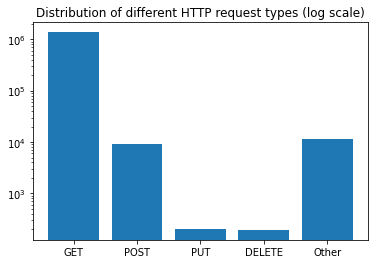

{'GET': 1369033, 'POST': 9260, 'PUT': 201, 'DELETE': 195, 'Other': 11306}


In [59]:
request_types = ['GET', 'POST', 'PUT','DELETE']
requests_count = len(df['request'])
requests_bins = {}
for request_type in request_types:
    request_type_count = len(df[df['request'].str.contains(request_type)])
    requests_bins[request_type] = request_type_count
requests_bins['Other'] = len(df['request']) - sum([value for value in requests_bins.values()])
plt.bar(requests_bins.keys(), requests_bins.values())
plt.title('Distribution of different HTTP request types')
plt.show()
plt.bar(requests_bins.keys(), requests_bins.values())
plt.yscale('log')
plt.title('Distribution of different HTTP request types (log scale)')
plt.show()
print(requests_bins)

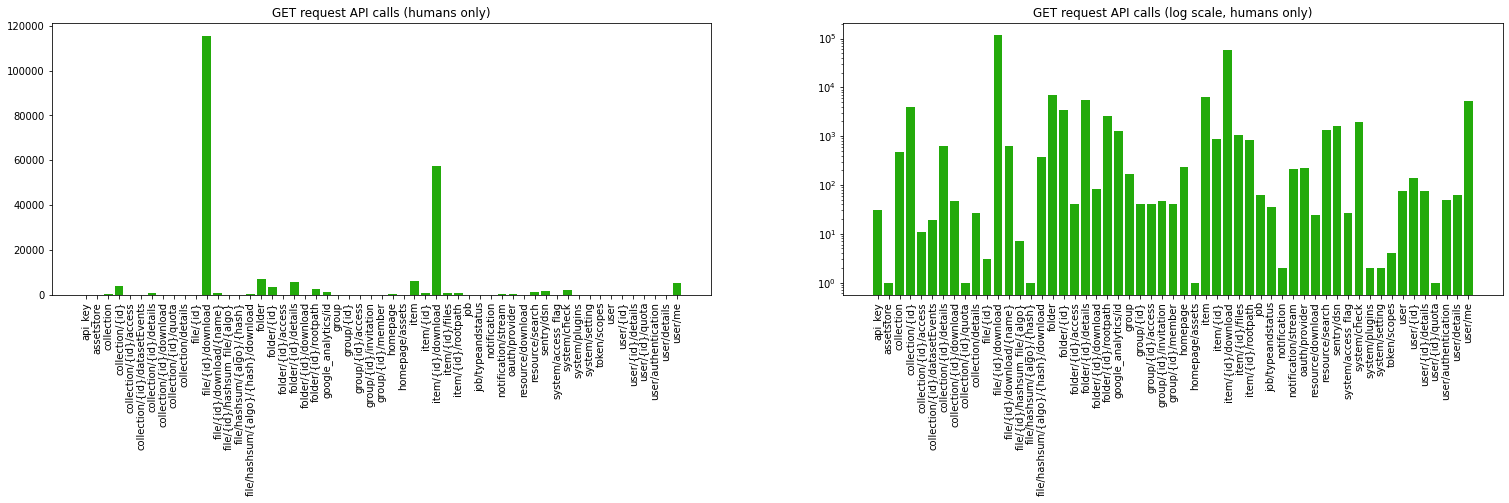

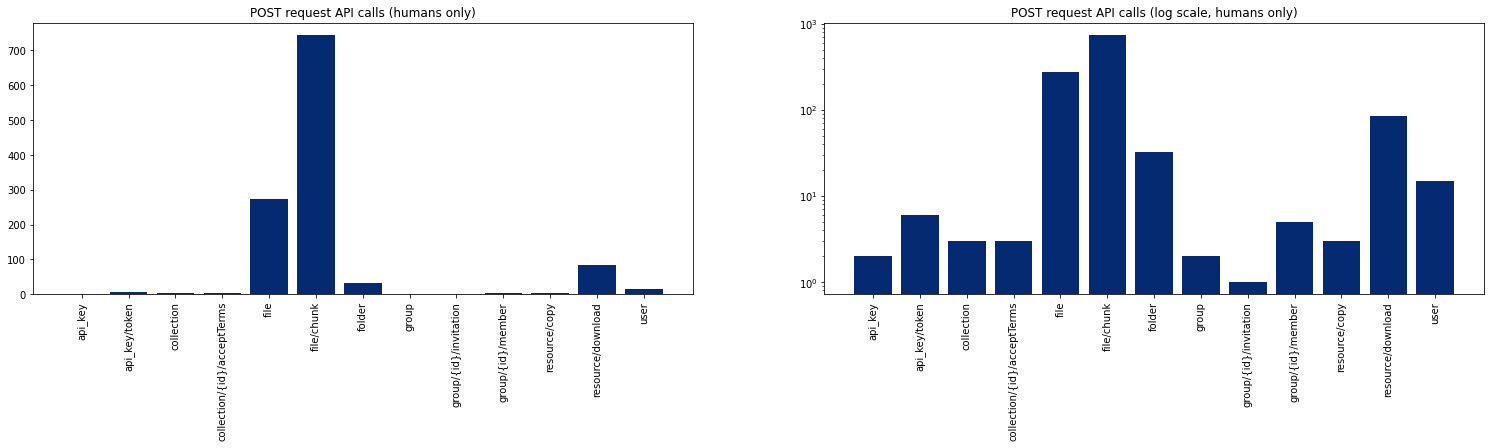

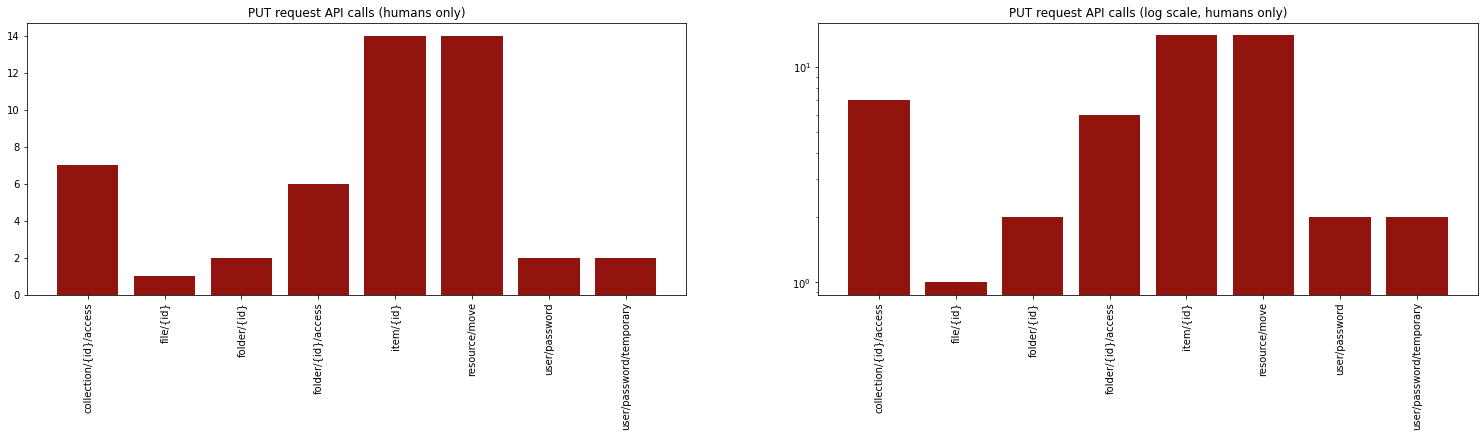

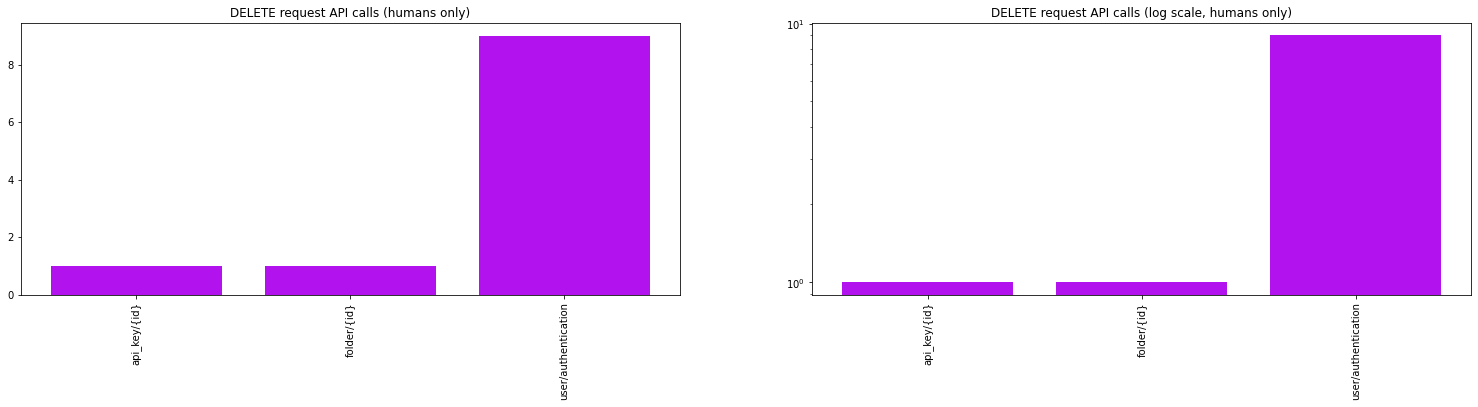

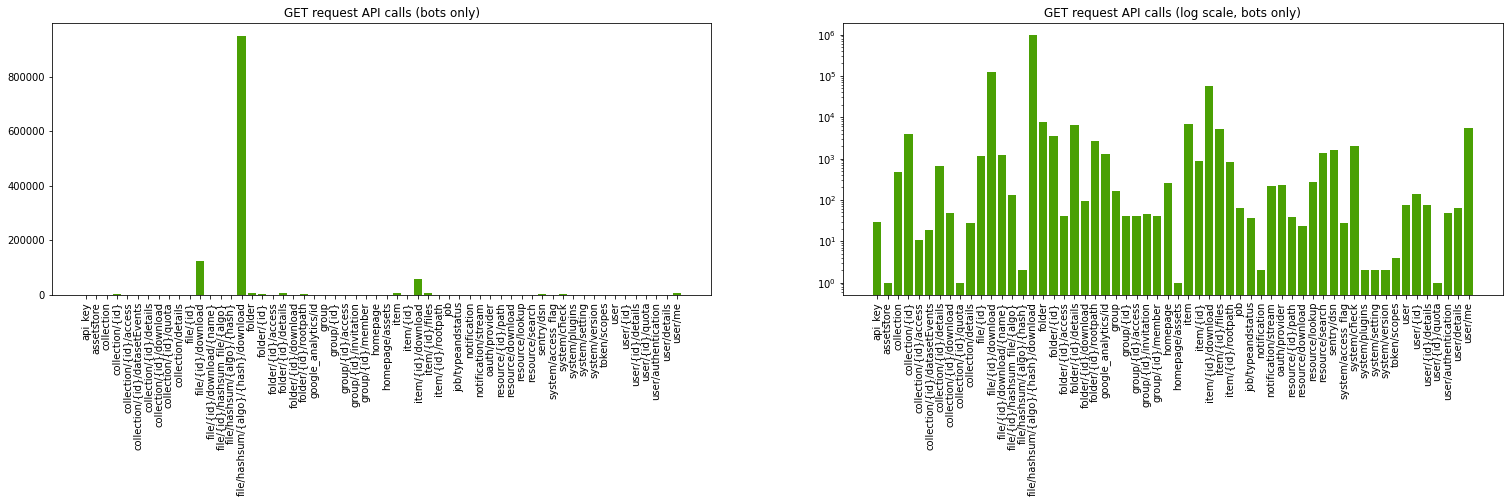

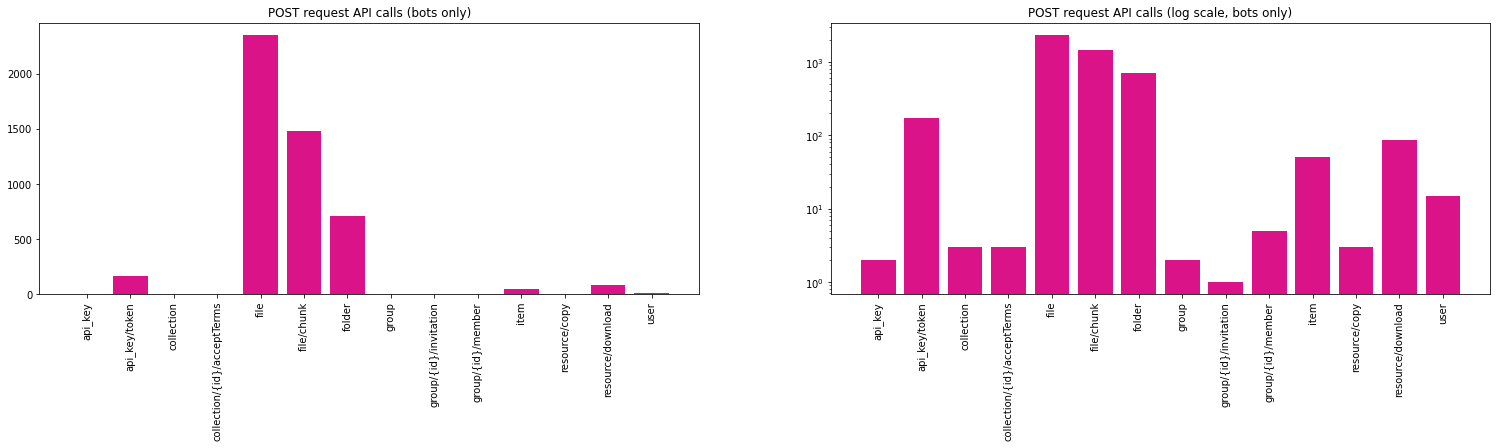

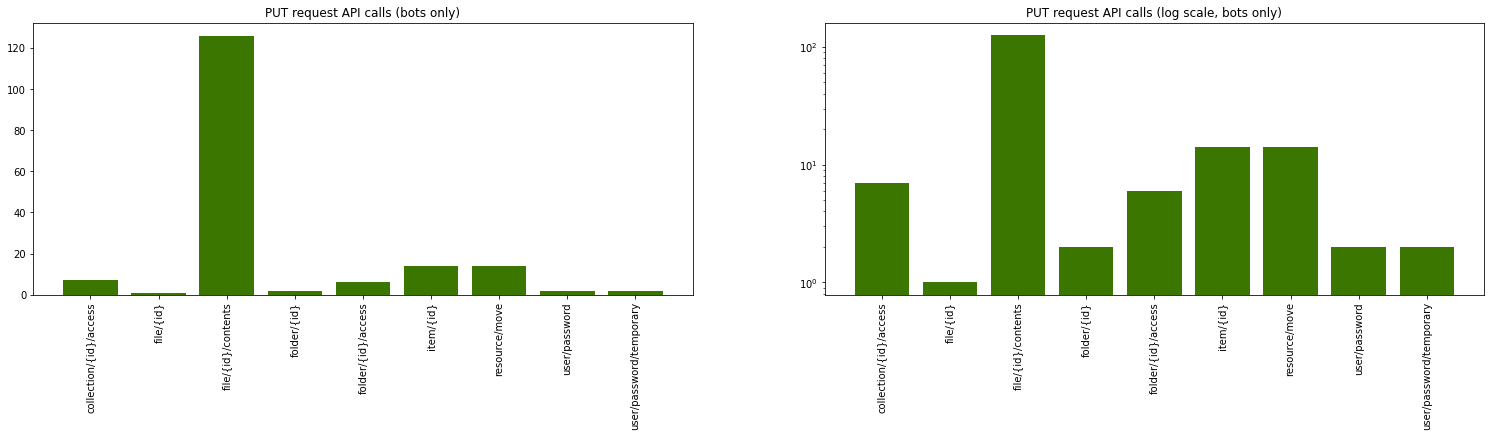

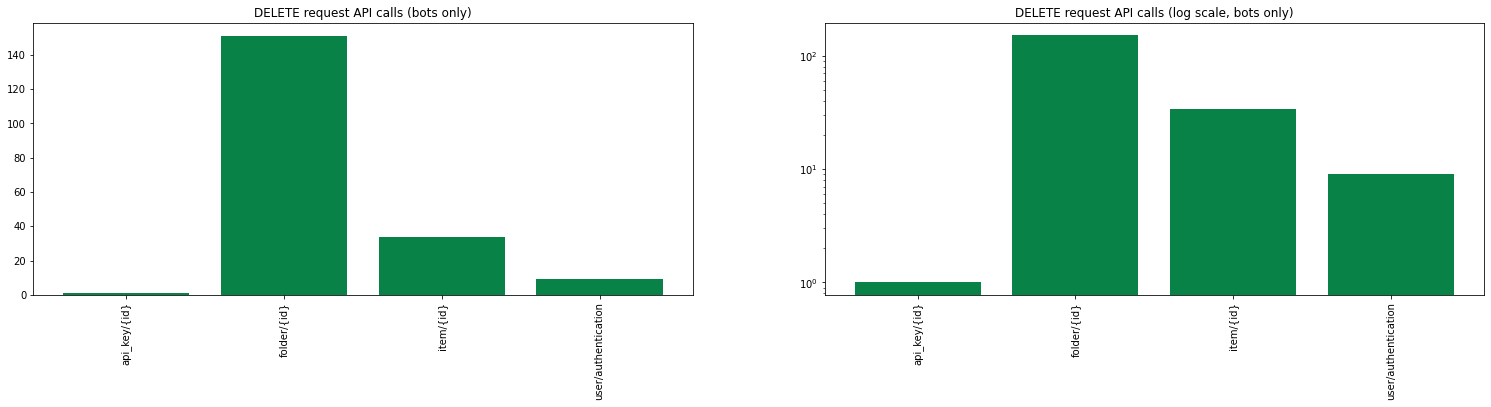

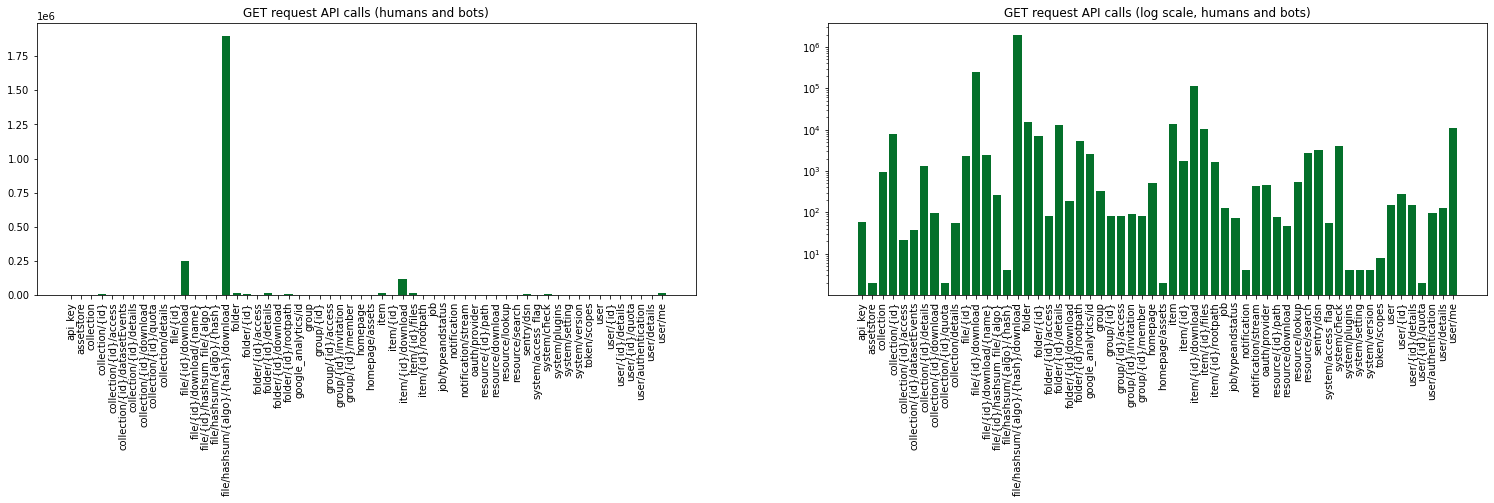

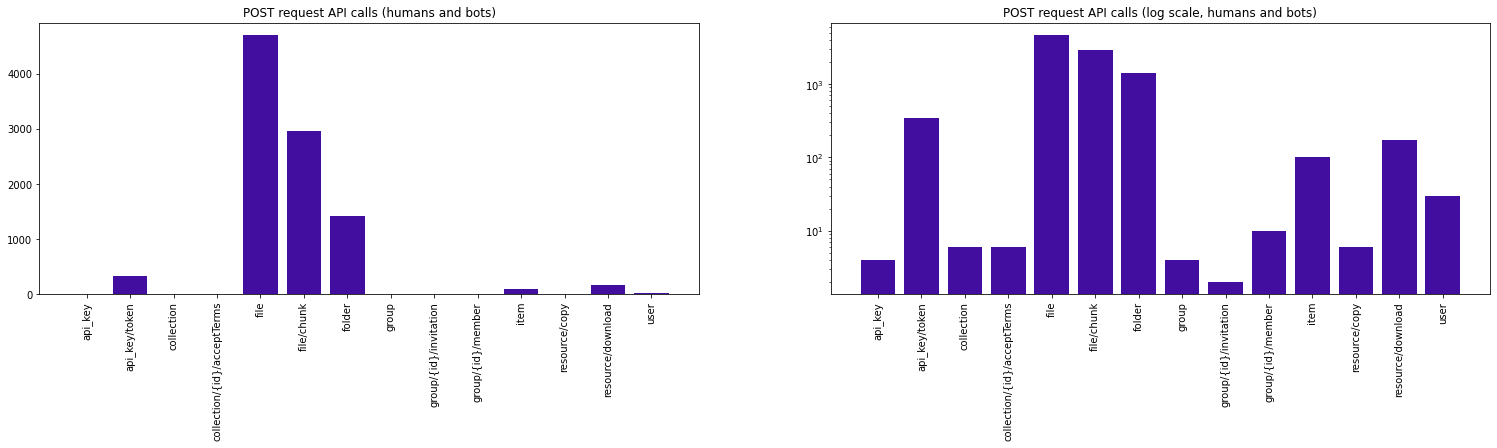

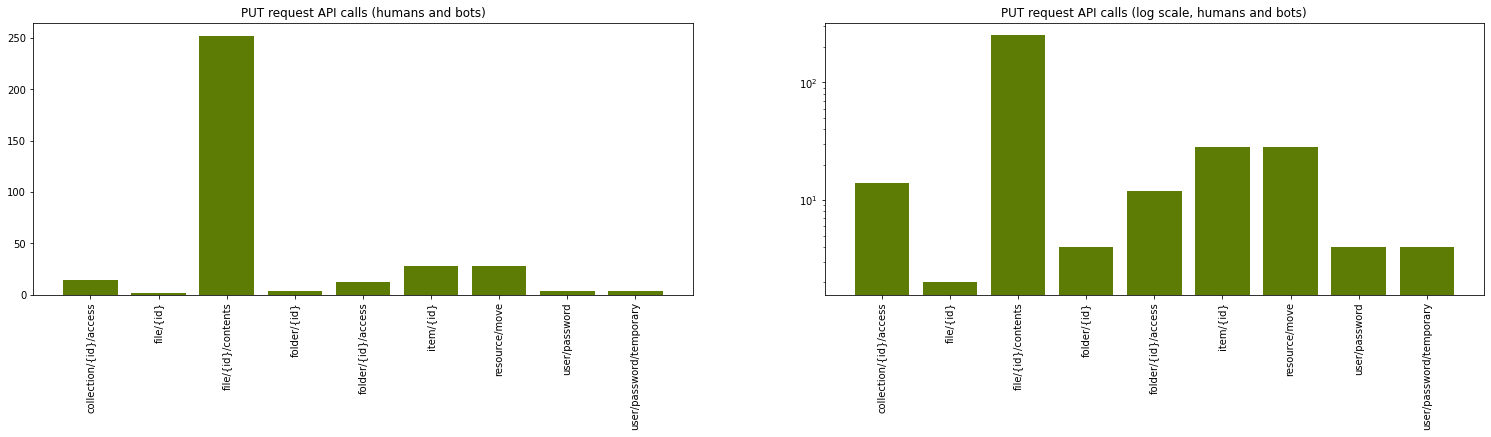

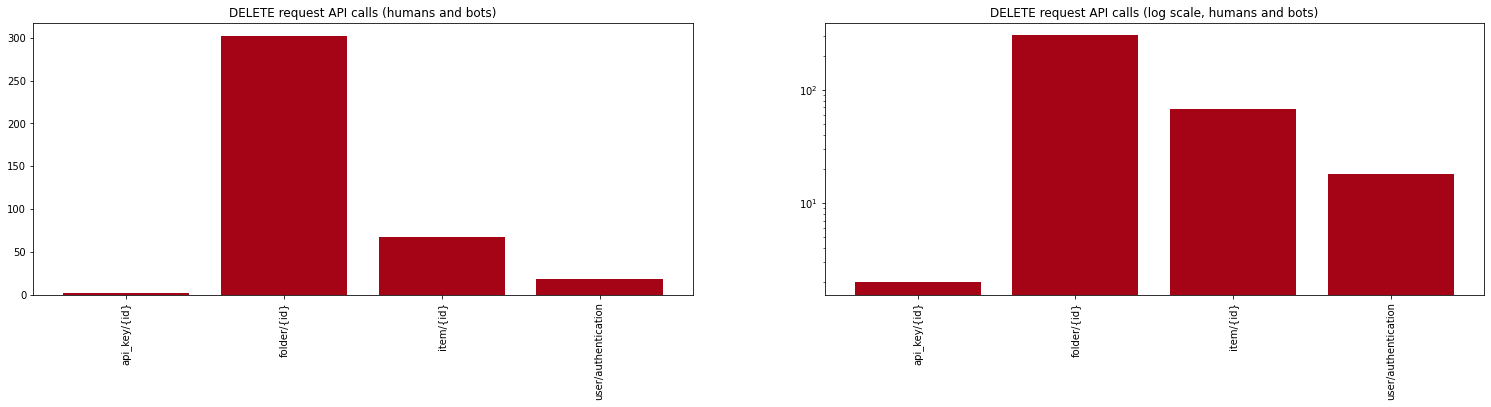

In [60]:
endpoints_bins = {}
not_used_threshold = 0
with open('api.json', 'r') as json_file:
    endpoints_bins = json.load(json_file)
for mode in ['humans only', 'bots only', 'humans and bots']:
    for request in (df['request'] if mode == 'humans and bots' else\
                    df_onlybots['request'] if mode == 'bots only' else df_nobots['request']):
        try:
            req_type = request.split(' ')[0][1:]
            endpoint = re.search("(?P<url>/[^\s]+)", request).group("url").replace('/api/v1/', '')
        except:
            continue

        endpoint = parse_endpoint(endpoint)
        
        if (req_type not in endpoints_bins or endpoint not in endpoints_bins[req_type]):
            continue
        
        endpoints_bins[req_type][endpoint] += 1

    for request_type in endpoints_bins:
        color = rand_color.generate(luminosity='dark')

        plt.gcf().set_size_inches(26, 5)
        plt.subplot(1, 2, 1)
        plt.bar(list(filter(lambda key: endpoints_bins[request_type][key] > not_used_threshold, list(endpoints_bins[request_type].keys()))),\
                list(filter(lambda val: val > not_used_threshold, list(endpoints_bins[request_type].values()))), color=color[0])
        plt.xticks(rotation=90)
        plt.title(str(request_type) + ' request API calls (' + str(mode) + ')')
        plt.yscale('linear')

        plt.subplot(1, 2, 2)
        plt.bar(list(filter(lambda key: endpoints_bins[request_type][key] > not_used_threshold, list(endpoints_bins[request_type].keys()))),\
                list(filter(lambda val: val > not_used_threshold, list(endpoints_bins[request_type].values()))), color=color[0])
        plt.xticks(rotation=90)
        plt.title(str(request_type) + ' request API calls (log scale, ' + str(mode) + ')')
        plt.yscale('log')
        plt.show()
        # pprint(sorted(endpoints_bins[request_type].items(), key=lambda x: x[1], reverse=True))
    print('\n')

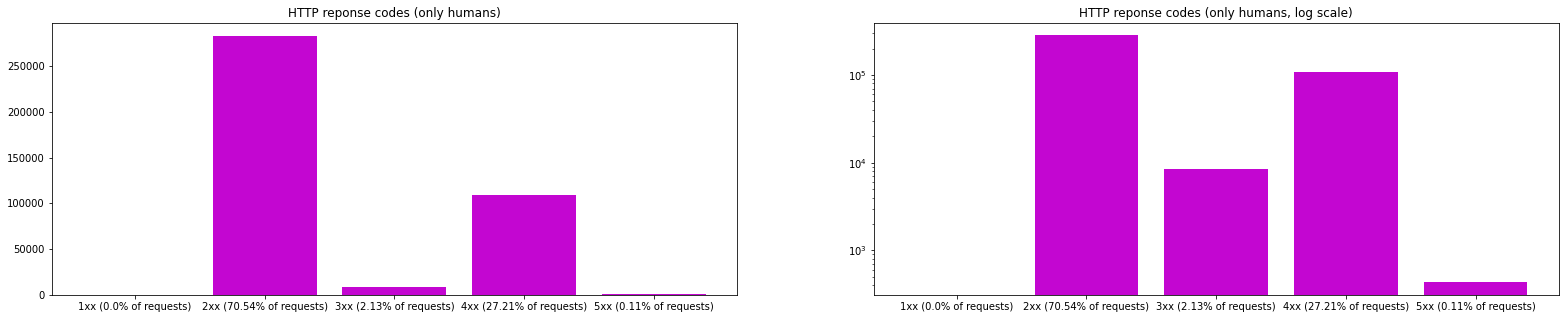

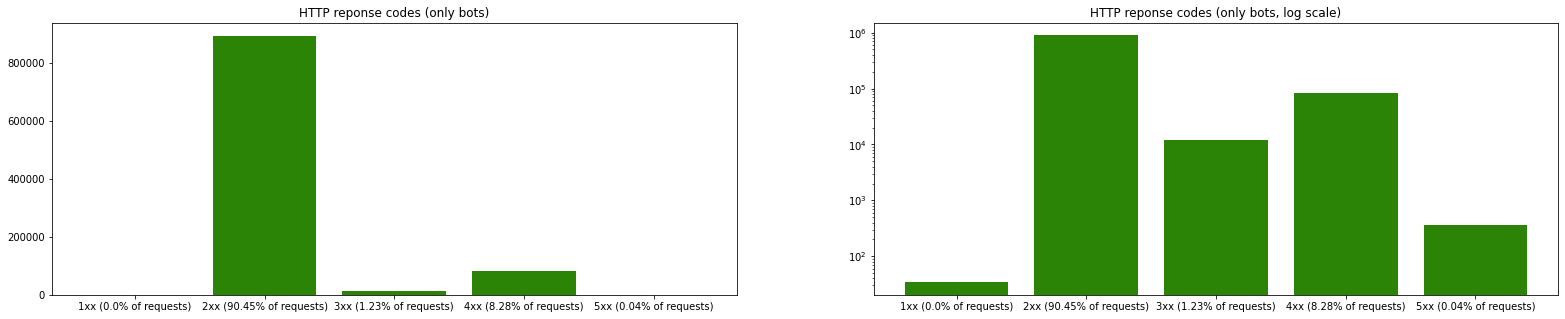

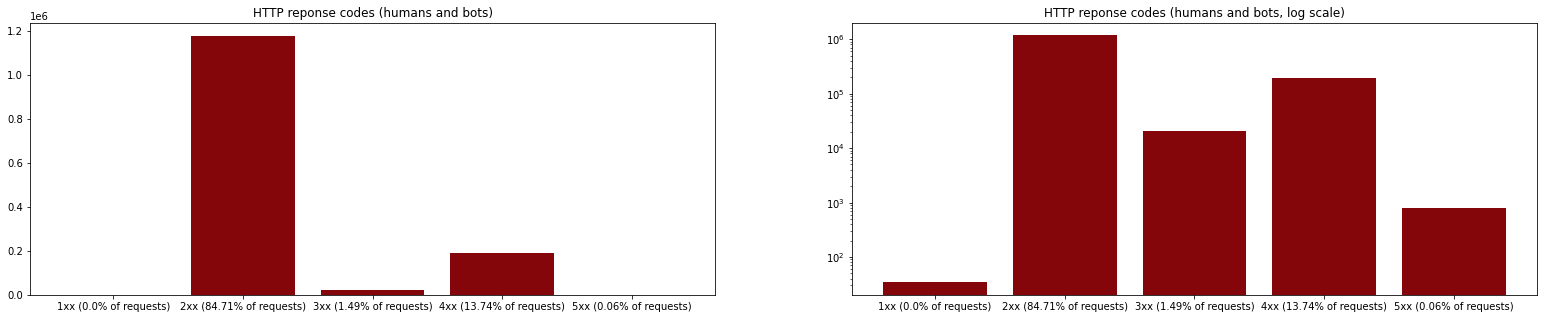

In [61]:
for mode in ['only humans', 'only bots', 'humans and bots']:
    statuses = {str(i) + 'xx': 0 for i in range(1, 6)}
    for status in df['status'] if mode=='humans and bots' else\
                  df_nobots['status'] if mode=='only humans' else\
                  df_onlybots['status']:
        statuses[str(int(status) // 100) + 'xx'] += 1

    xs = [str(key) + ' (' + str(round((statuses[key] / (\
          human_req_count if mode == 'only humans' else\
          bot_req_count if mode == 'only bots' else\
          human_and_bot_req_count)) * 100, 2)) + \
          '% of requests)' for key in statuses.keys()]

    color = rand_color.generate(luminosity='dark')

    plt.gcf().set_size_inches(27, 5)
    plt.subplot(1, 2, 1)
    plt.bar(xs, statuses.values(), color=color[0])
    plt.title('HTTP reponse codes (' + mode + ')')
    plt.yscale('linear')

    plt.gcf().set_size_inches(27, 5)
    plt.subplot(1, 2, 2)
    plt.bar(xs, statuses.values(), color=color[0])
    plt.title('HTTP reponse codes (' + mode + ', log scale)')
    plt.yscale('log')
    plt.show()

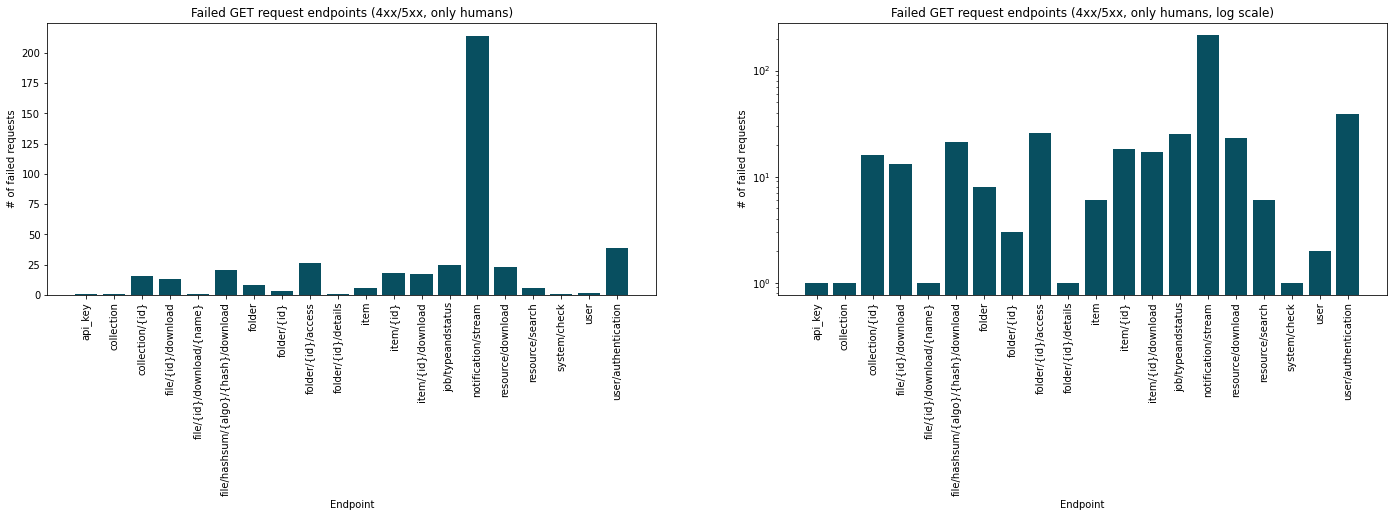

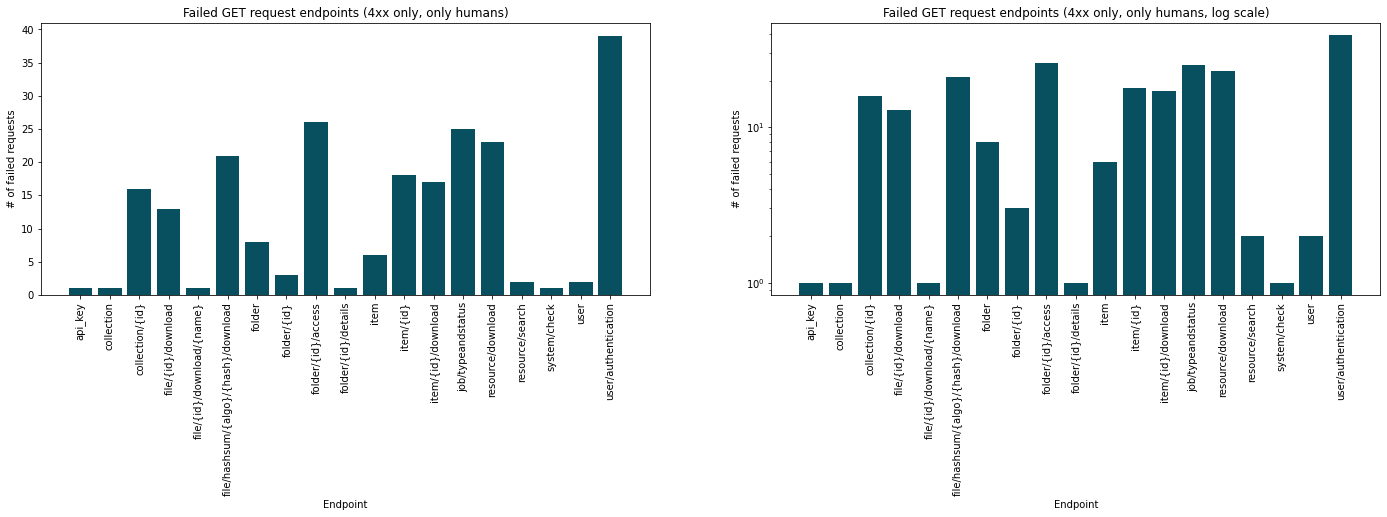

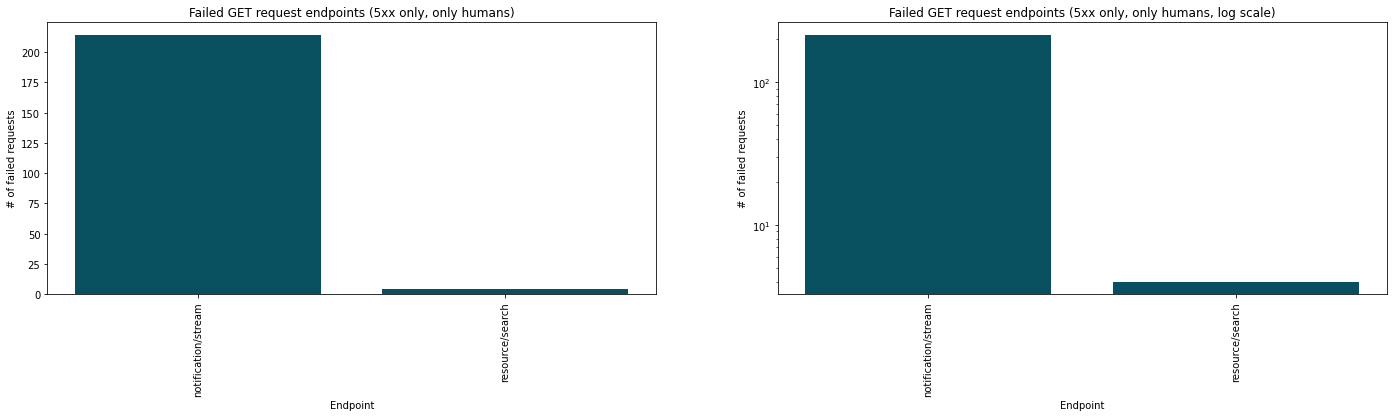

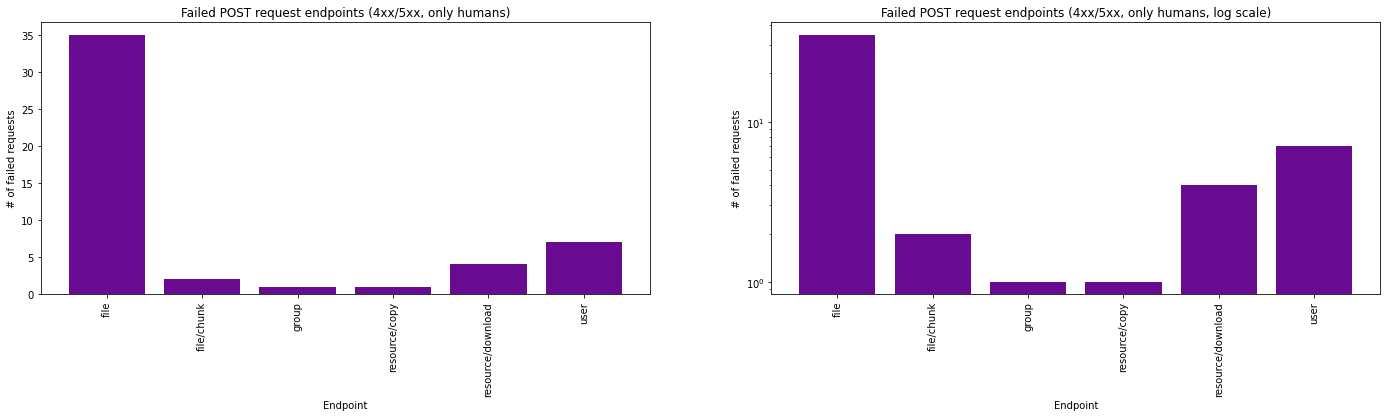

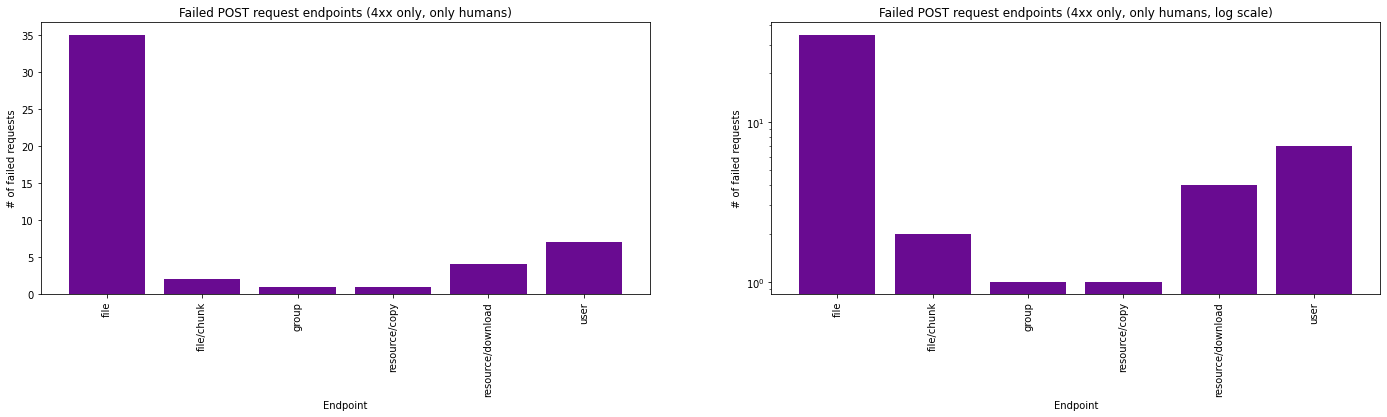

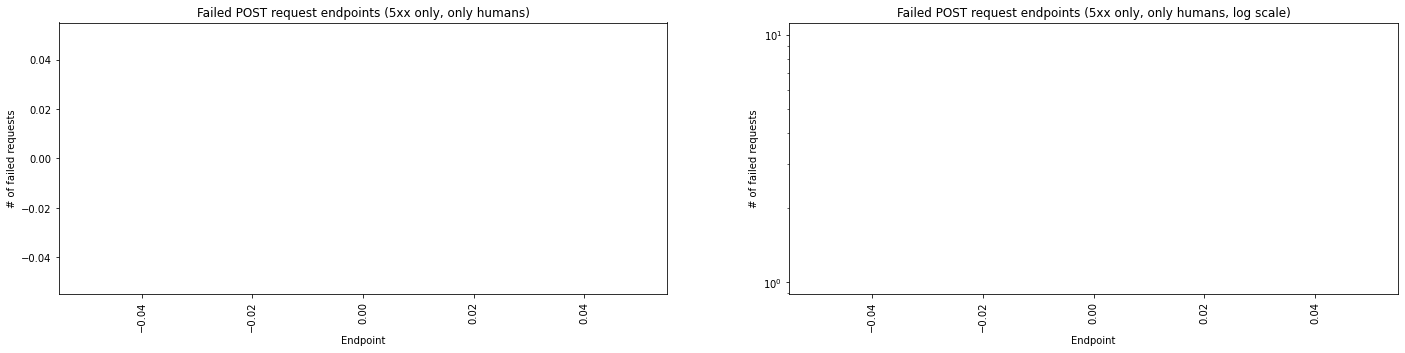

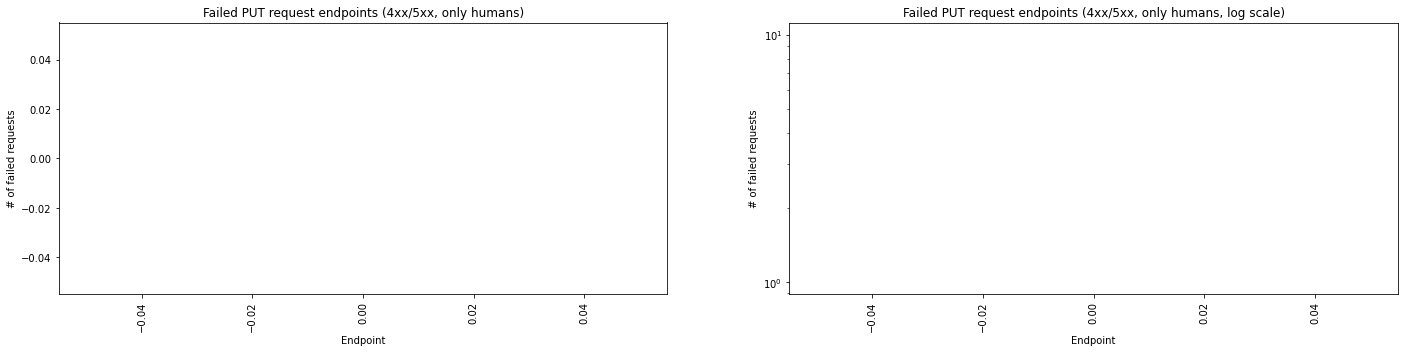

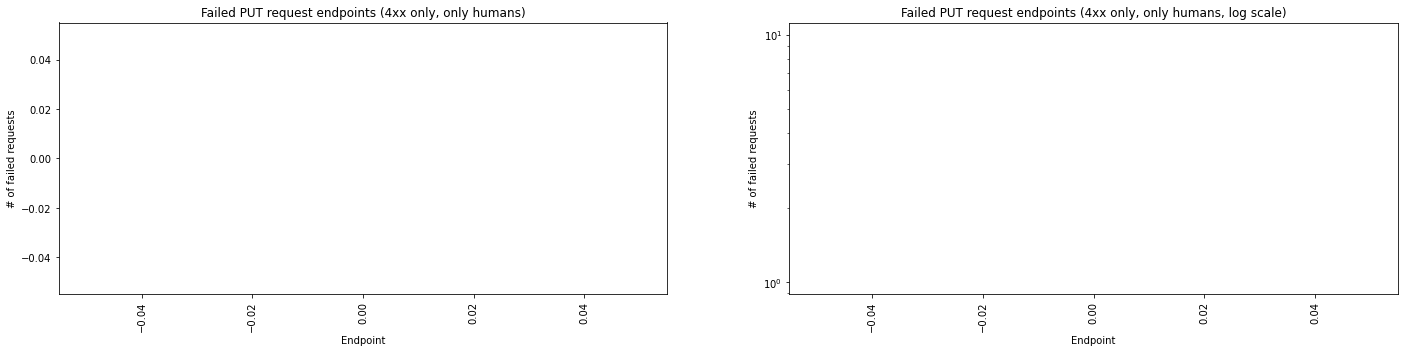

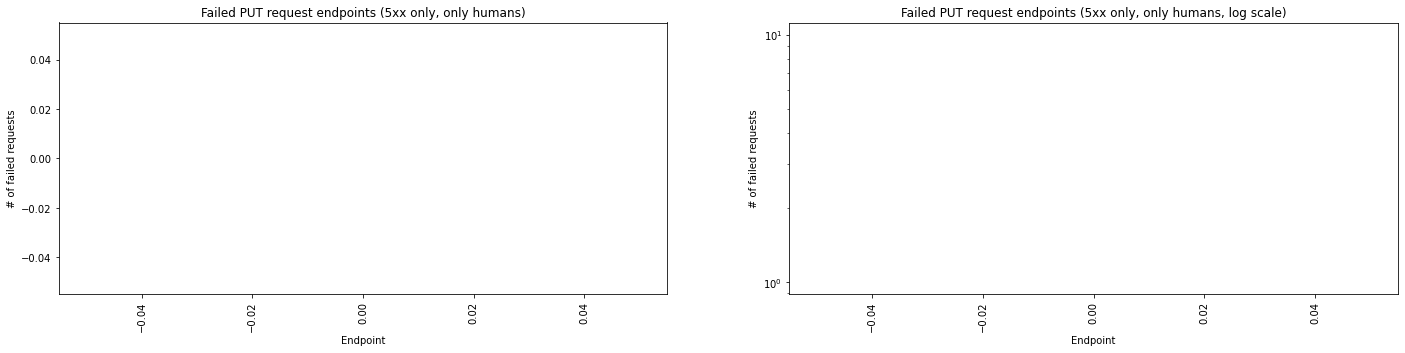

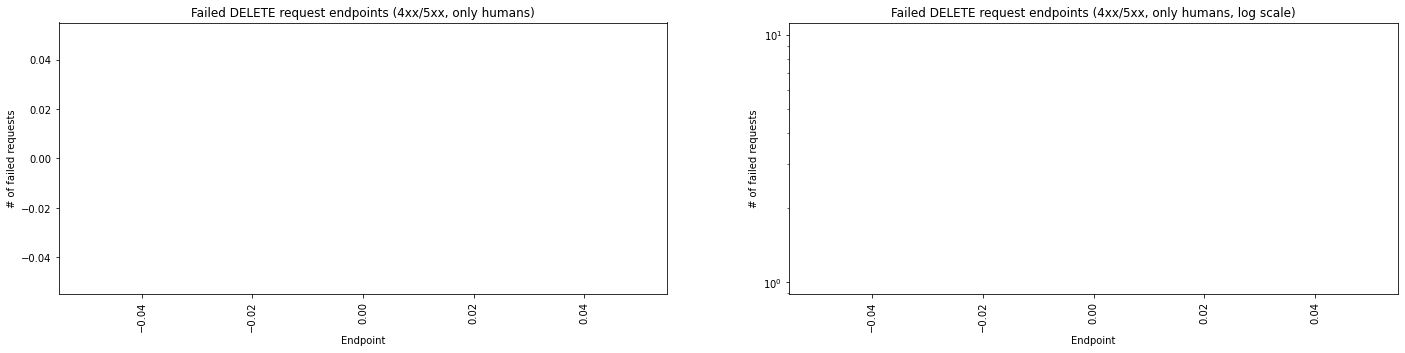

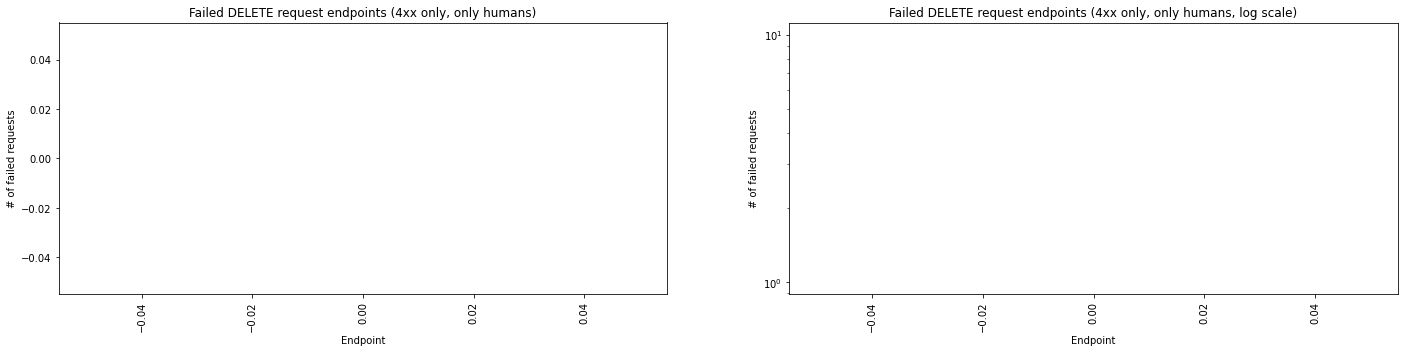

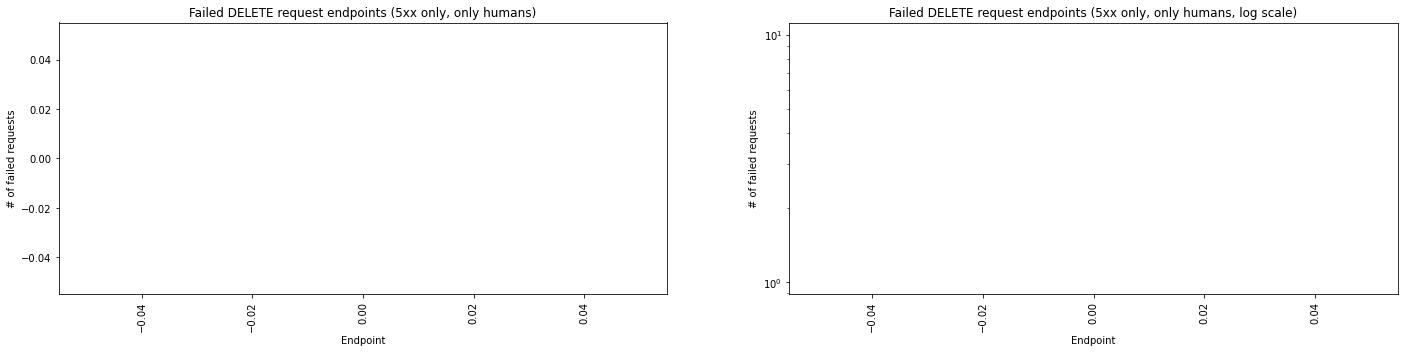

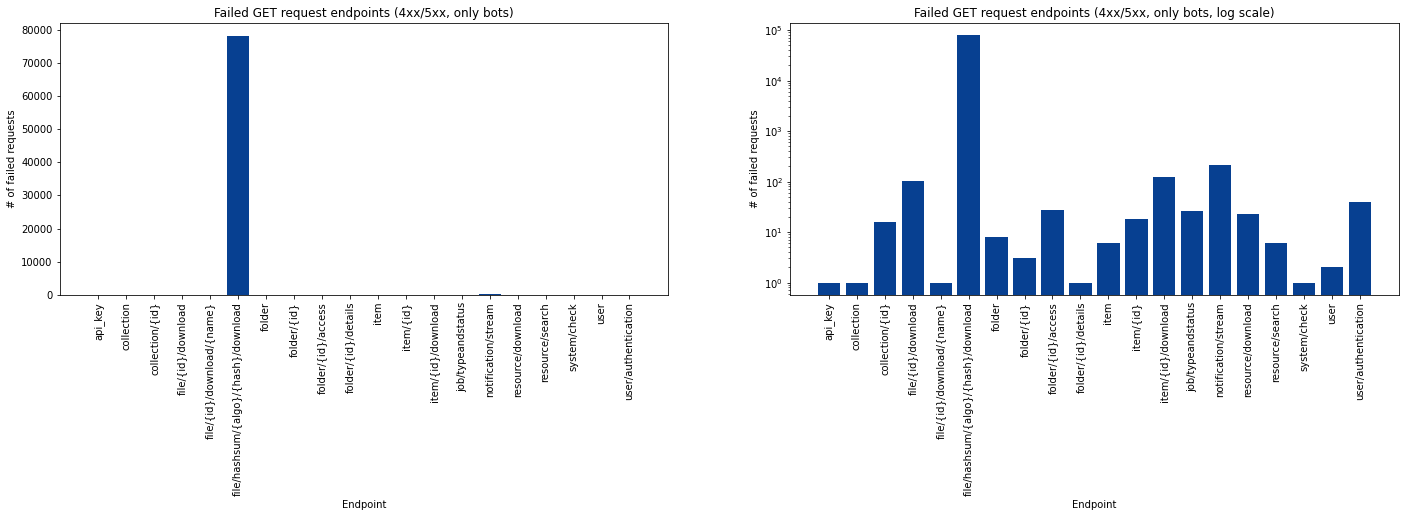

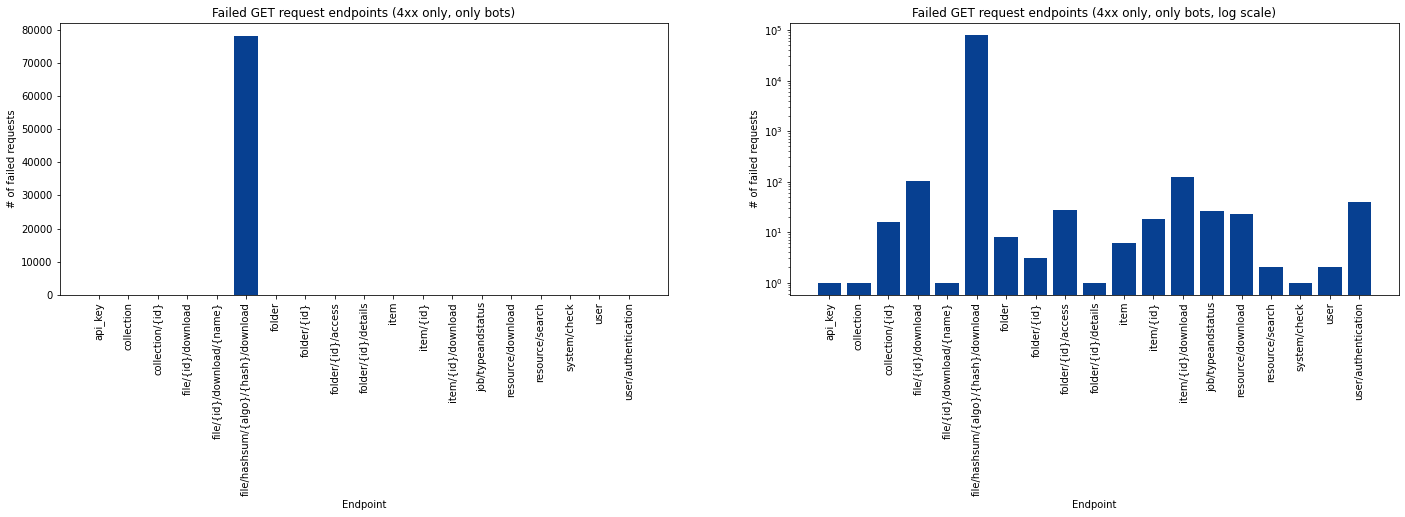

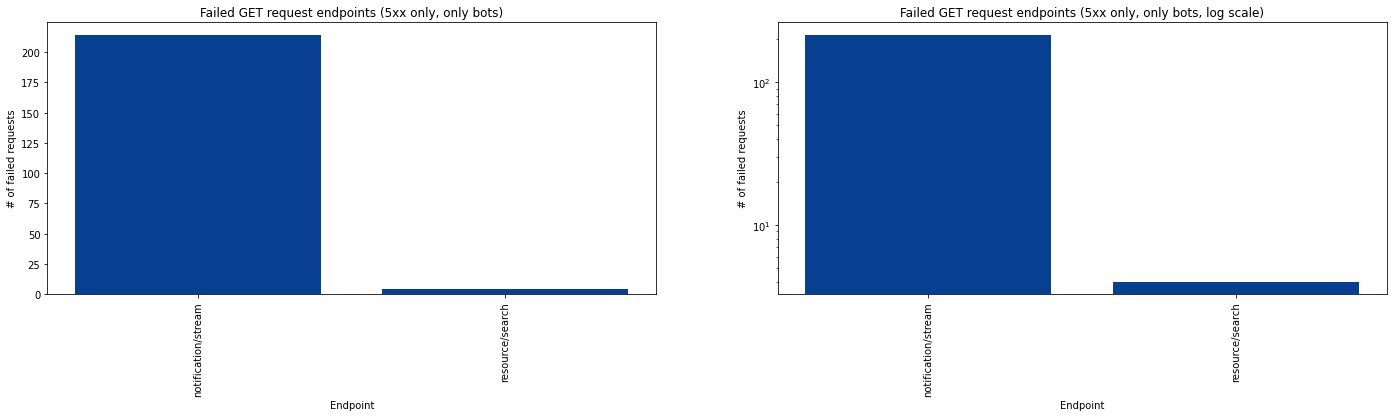

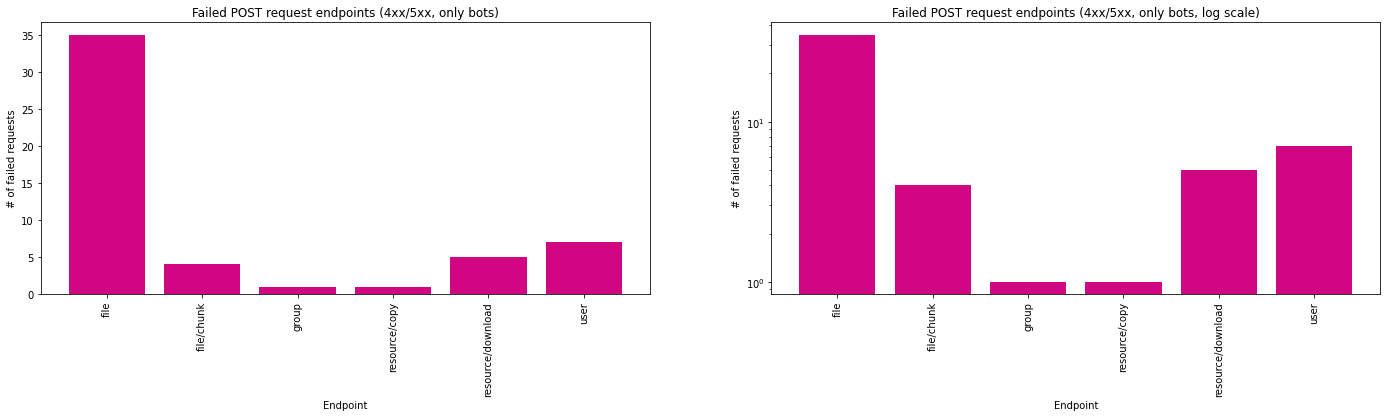

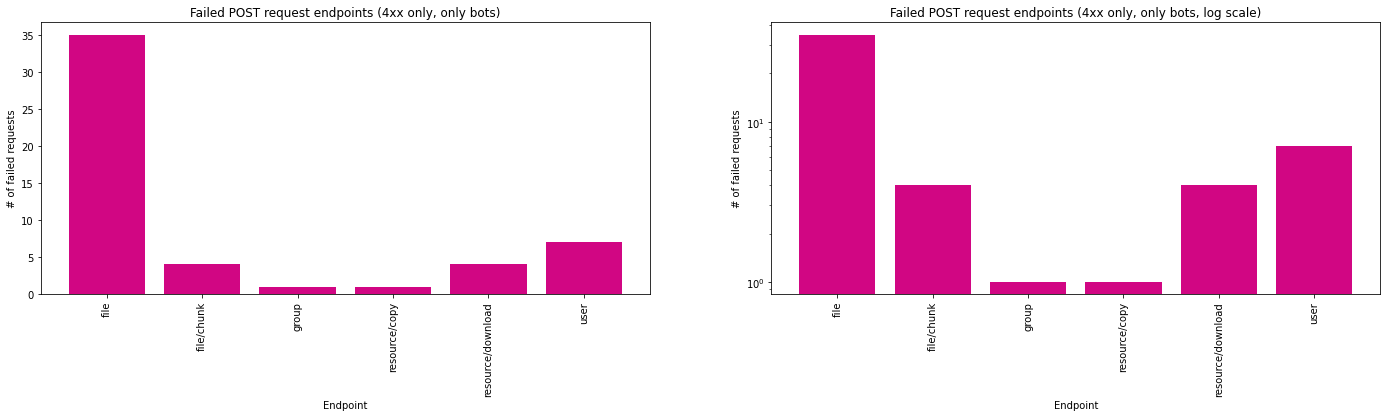

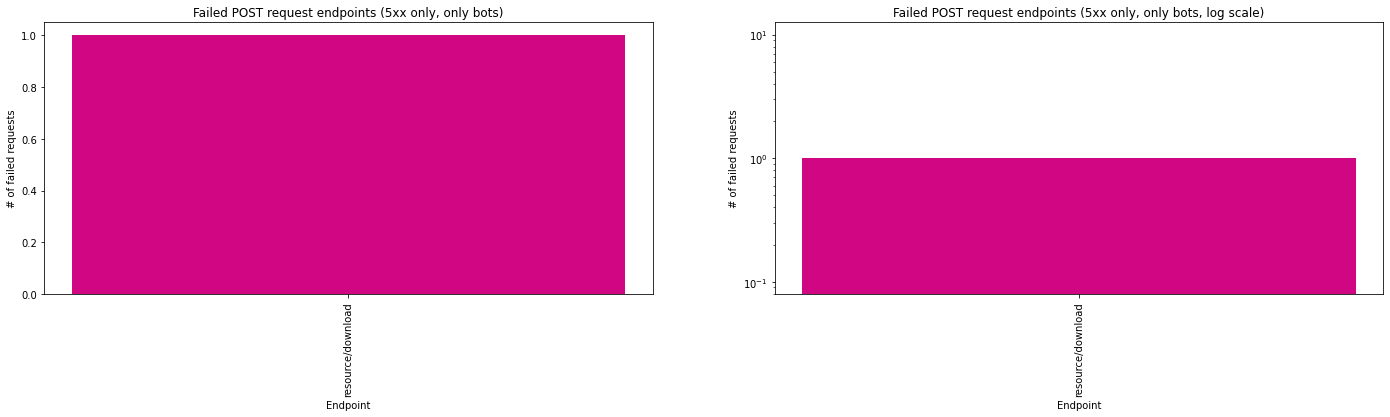

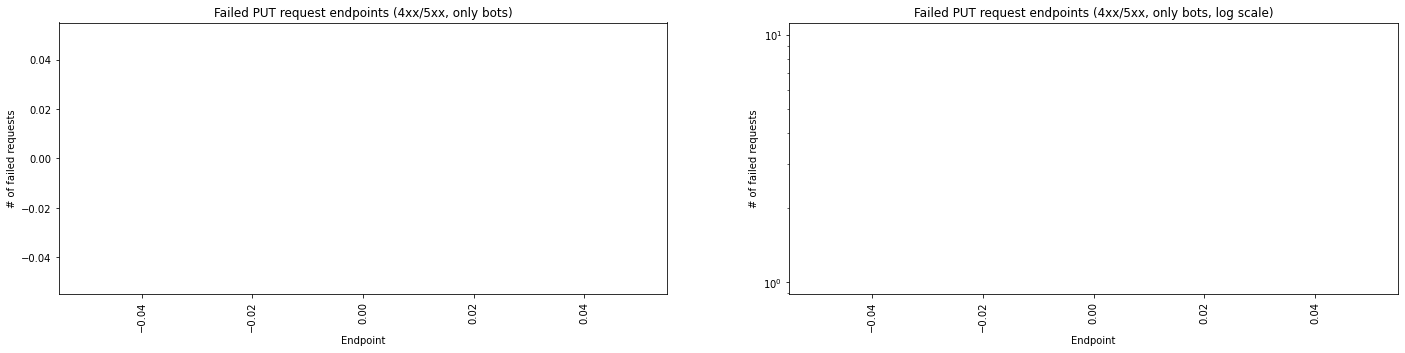

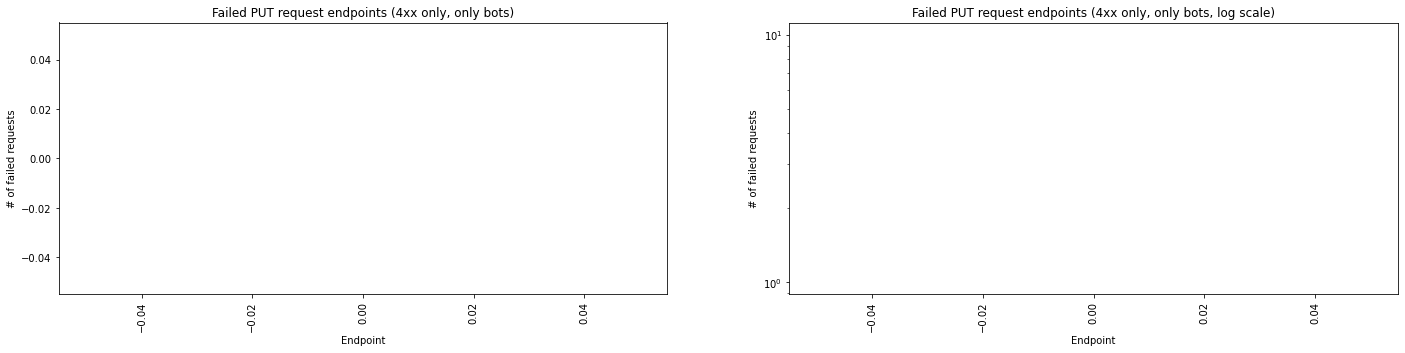

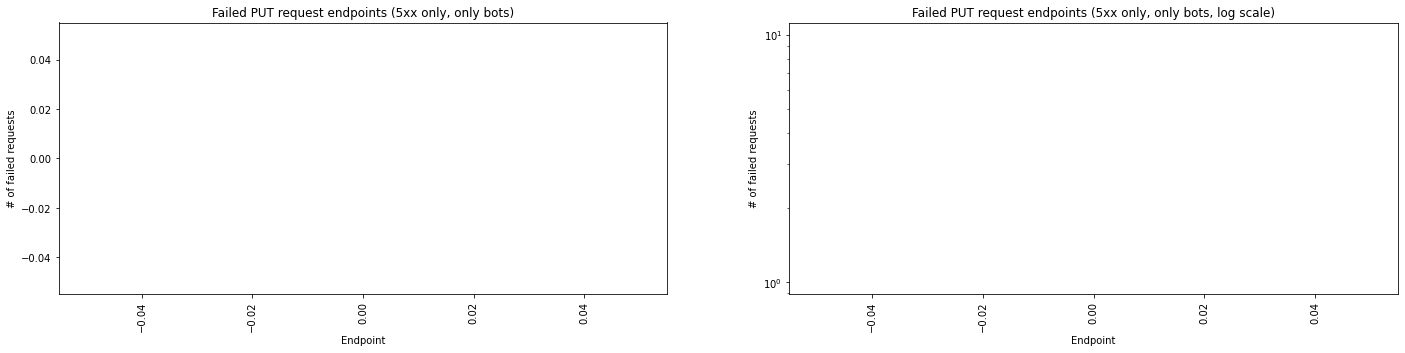

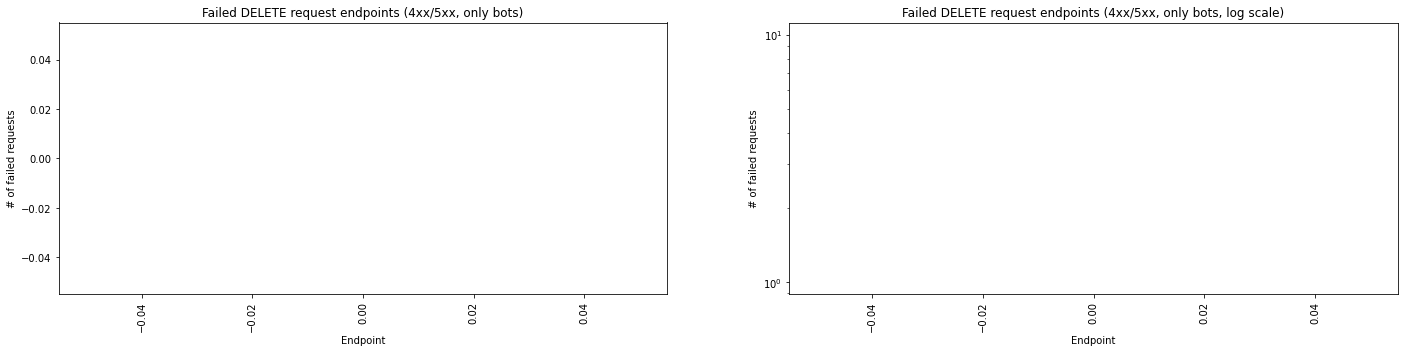

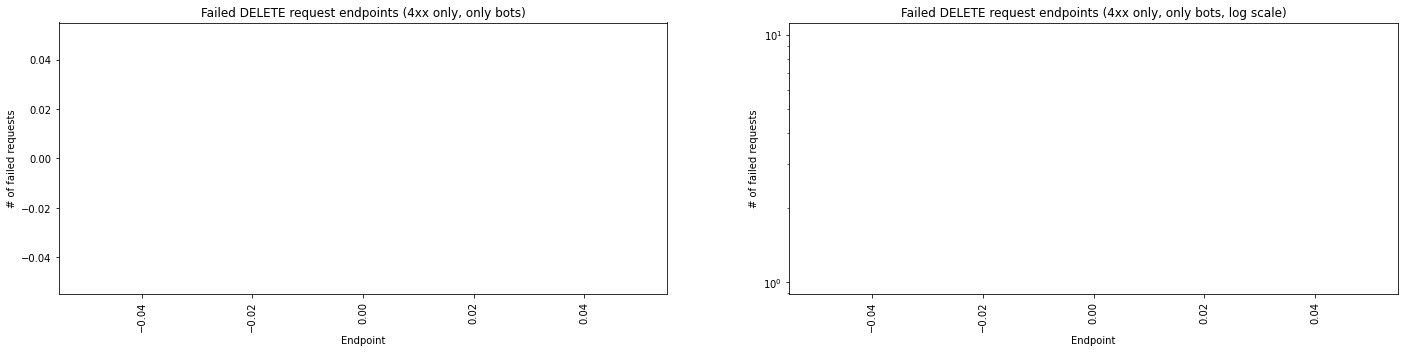

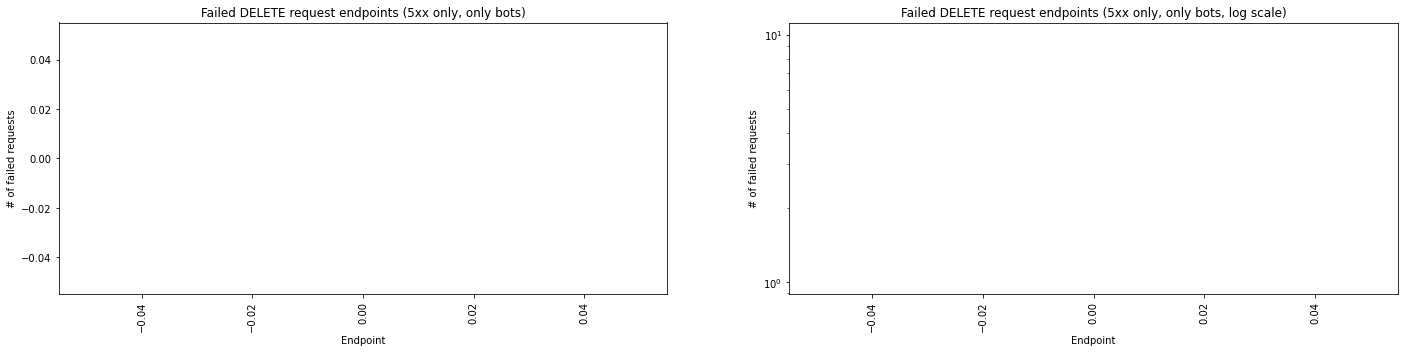

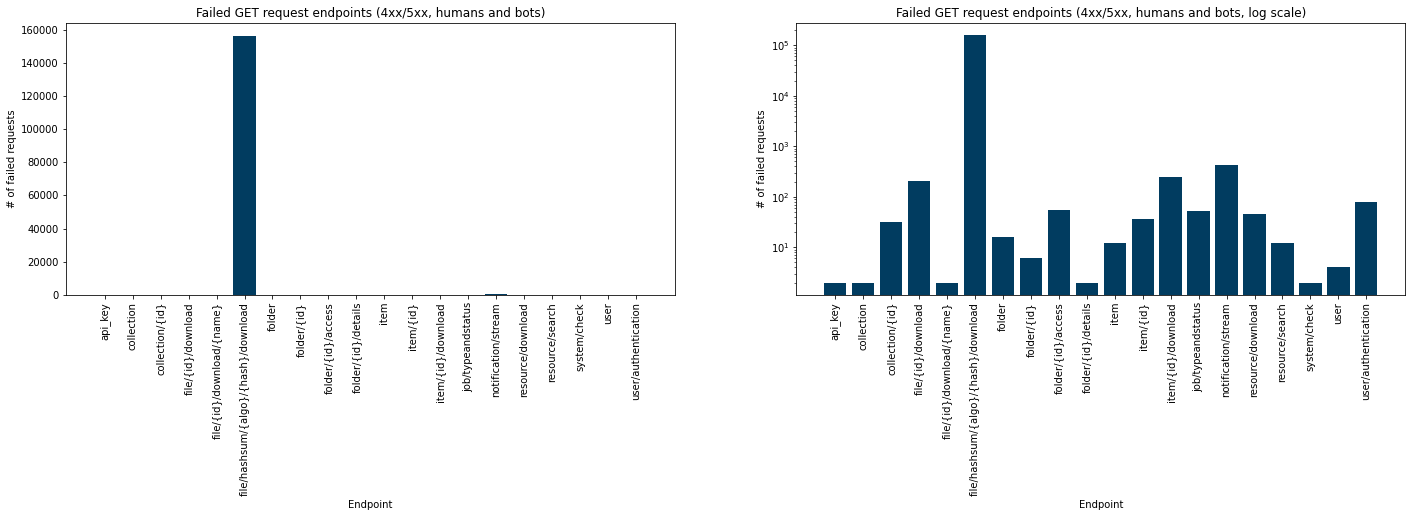

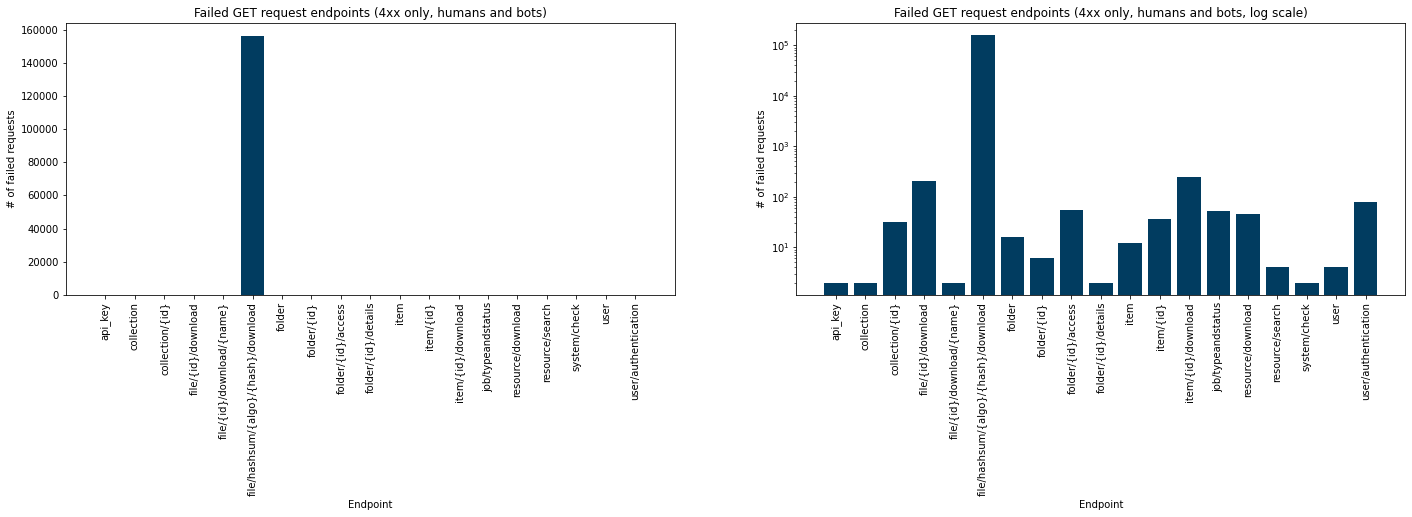

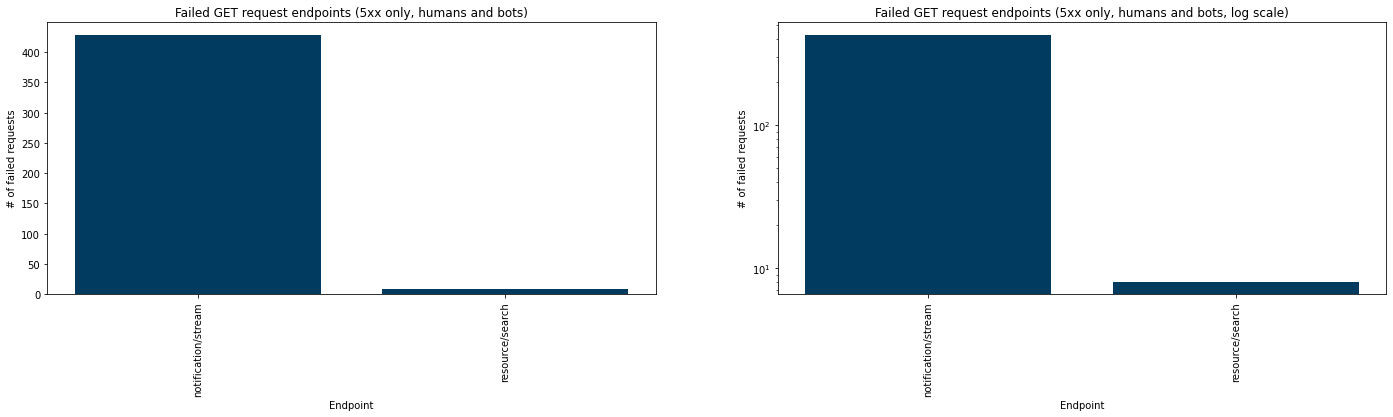

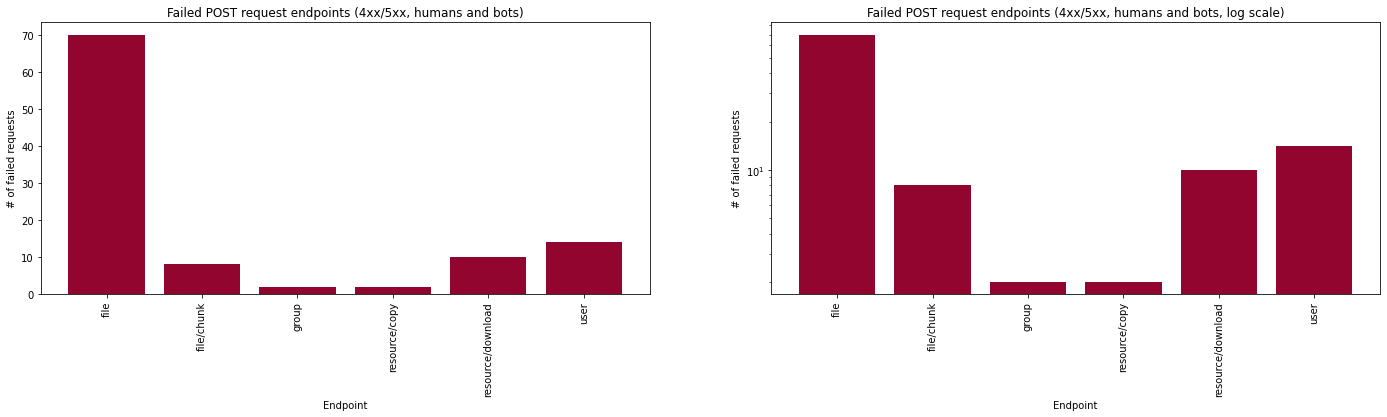

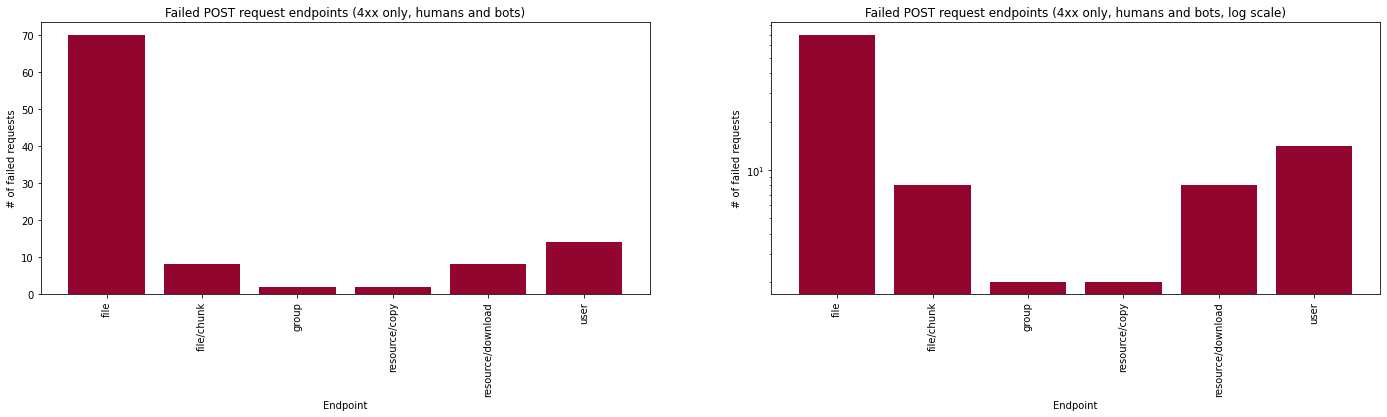

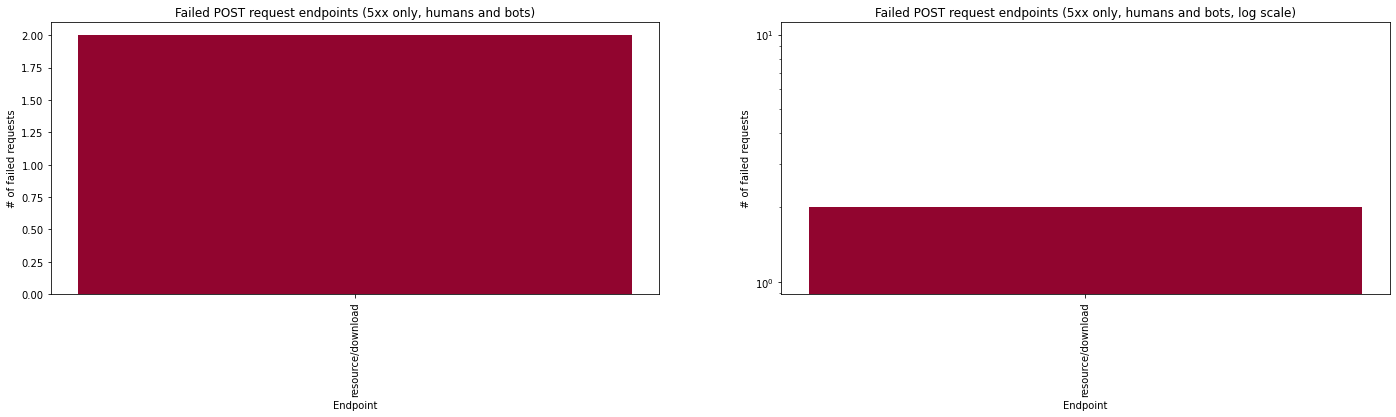

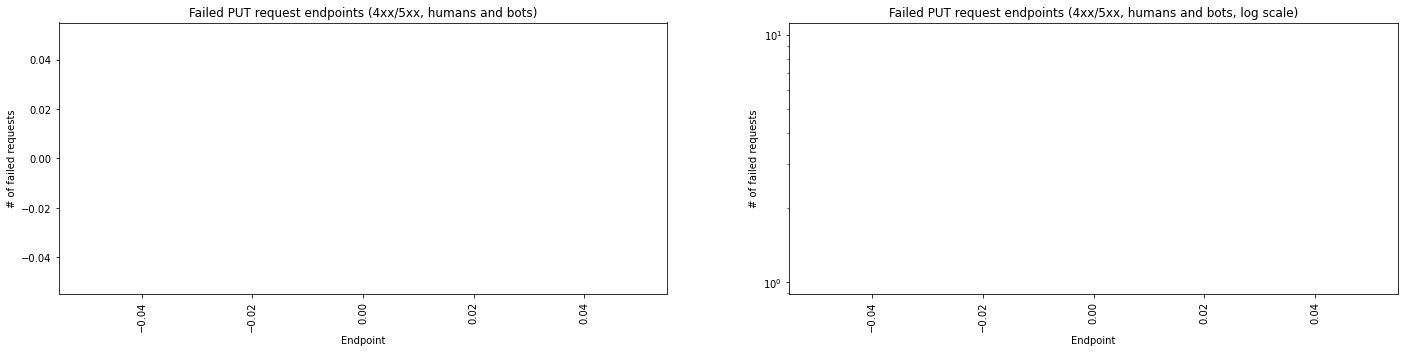

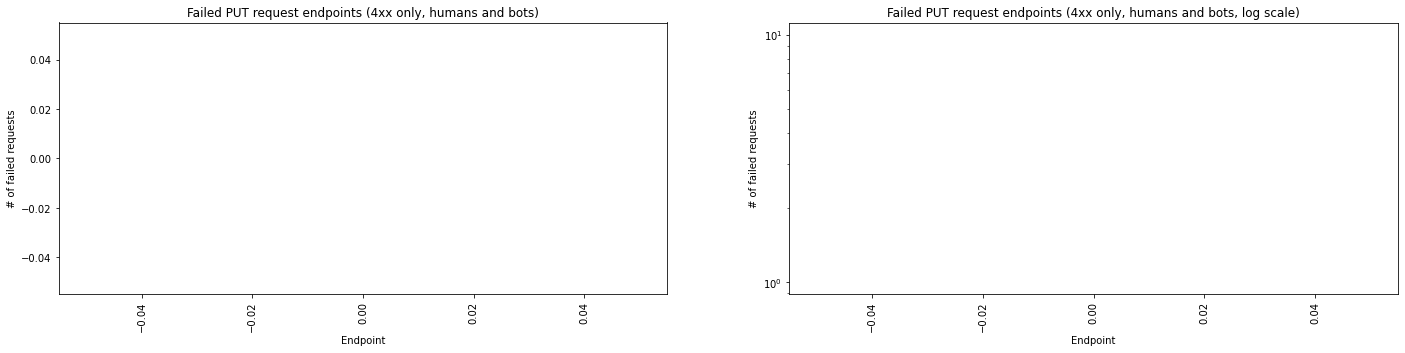

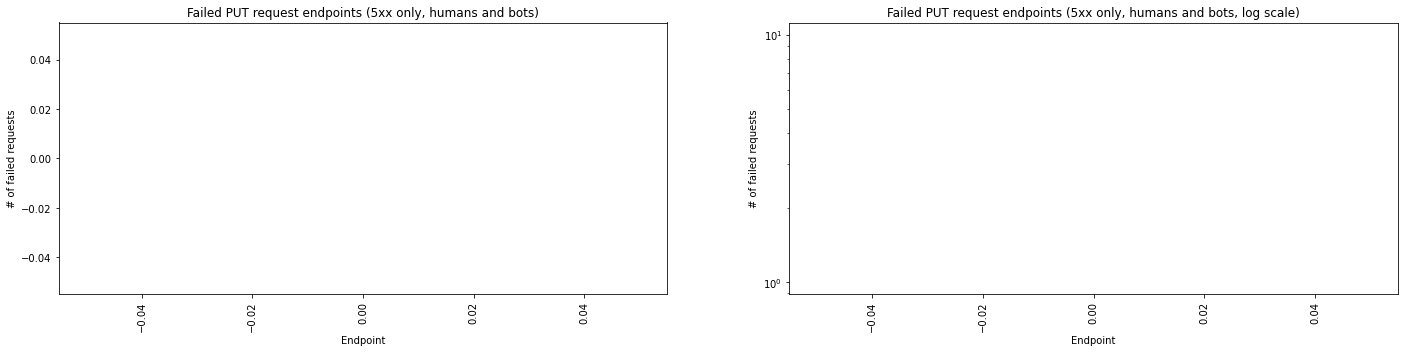

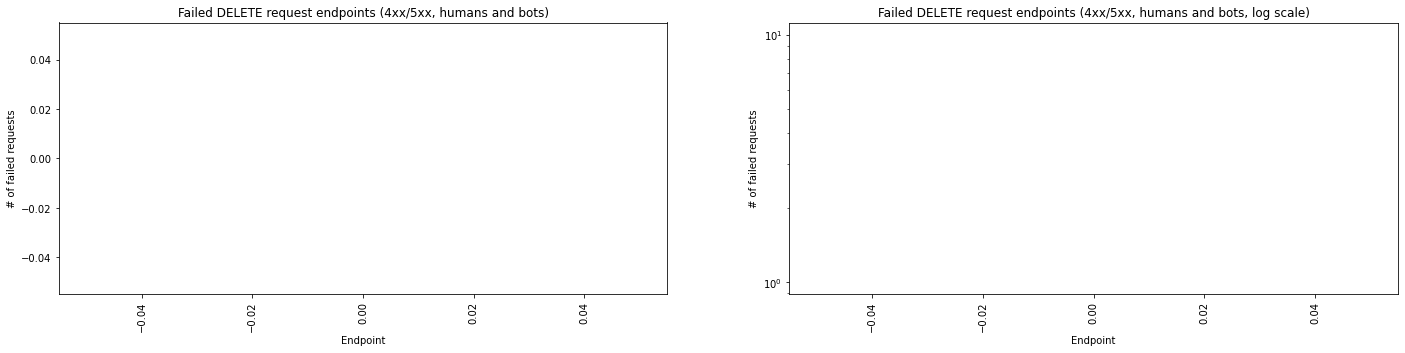

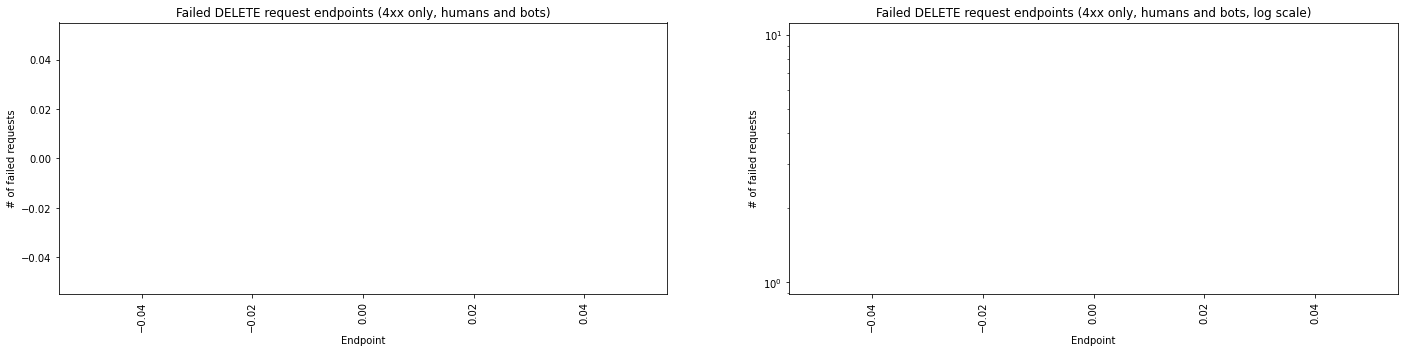

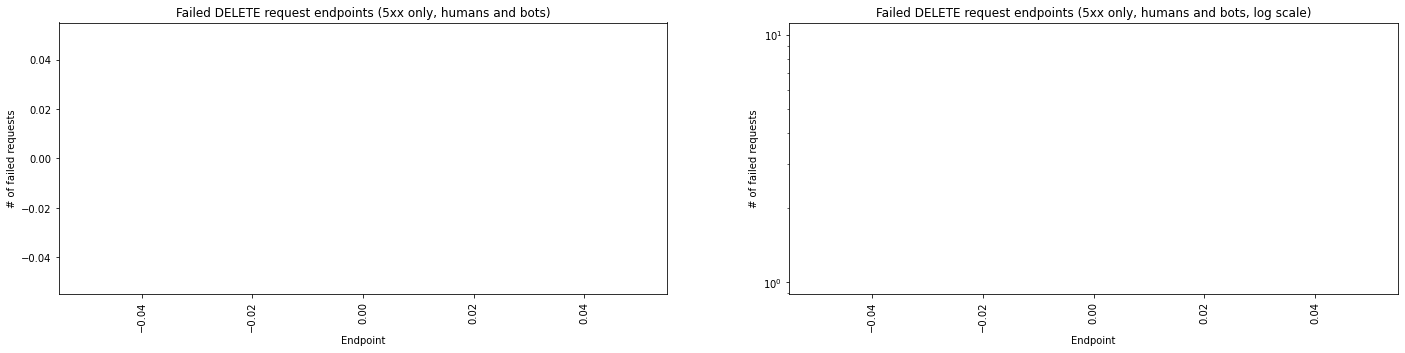

In [62]:
from copy import deepcopy
error_endpoints = {}
error_400_endpoints = {}
error_500_endpoints = {}
request_types = ['GET', 'POST', 'PUT','DELETE']
with open('api.json', 'r') as json_file:
    error_endpoints = json.load(json_file)
error_400_endpoints = deepcopy(error_endpoints)
error_500_endpoints = deepcopy(error_endpoints)

for mode in ['only humans', 'only bots', 'humans and bots']:
    current_df = df if mode == 'humans and bots' else df_onlybots if mode == 'only bots'\
                 else df_nobots
    for status, request in zip(current_df['status'], current_df['request']):
        status = (int(status) // 100) * 100 # convert to a multiple of 100
        if status < 400: # skip if no error
            continue
        try:
            req_type = request.split(' ')[0][1:]
            endpoint = re.search("(?P<url>/[^\s]+)", request).group("url").replace('/api/v1/', '')
        except:
            continue
        endpoint = parse_endpoint(endpoint)

        if req_type not in error_endpoints or endpoint not in error_endpoints[req_type]:
            continue

        error_endpoints[req_type][endpoint] += 1
        if status == 400:
            if endpoint not in error_400_endpoints[req_type]:
                error_400_endpoints[req_type][endpoint] = 1
            else:
                error_400_endpoints[req_type][endpoint] += 1
        else:
            if endpoint not in error_500_endpoints[req_type]:
                error_500_endpoints[req_type][endpoint] = 1
            else:
                error_500_endpoints[req_type][endpoint] += 1

    color = rand_color.generate(luminosity='dark', count=len(error_endpoints.keys()))
    for index, req_type in enumerate(error_endpoints.keys()):
        for include in ['4xx/5xx', '4xx only', '5xx only']:
            xs = {}
            if include == '4xx/5xx':
                xs = error_endpoints
            elif include == '4xx only':
                xs = error_400_endpoints
            elif include == '5xx only':
                xs = error_500_endpoints

            xs[req_type] = {key: val for key, val in xs[req_type].items() if val > 0}
            
            plt.gcf().set_size_inches(24, 5)
            plt.subplot(1, 2, 1)
            plt.bar(xs[req_type].keys(), xs[req_type].values(), color=color[index])
            plt.xticks(rotation=90)
            plt.title('Failed ' + req_type + ' request endpoints (' + include + ', ' + mode + ')')
            plt.ylabel('# of failed requests')
            plt.xlabel('Endpoint')
            plt.yscale('linear')


            plt.subplot(1, 2, 2)
            plt.gcf().set_size_inches(24, 5)
            plt.bar(xs[req_type].keys(), xs[req_type].values(), color=color[index])
            plt.xticks(rotation=90)
            plt.title('Failed ' + req_type + ' request endpoints (' + include + ', ' + mode + ', log scale)')
            plt.ylabel('# of failed requests')
            plt.xlabel('Endpoint')
            plt.yscale('log')
            plt.show()
        print('\n')

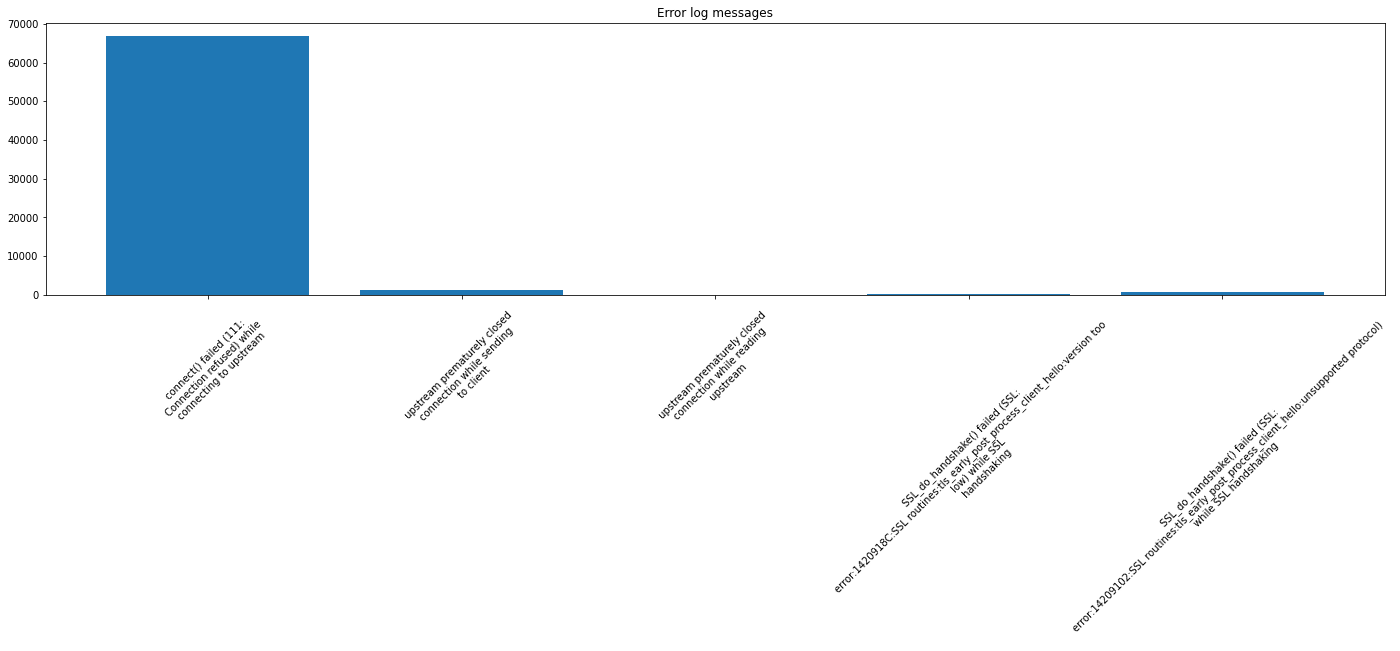

In [63]:
errors = {}
for err in errors_df['message']:
    err = err.split(',')[0]
    err_len = len(err)
    err = err.split(' ')
    err_formatted = ""
    current_len = 0
    for index, word in enumerate(err):
        if index % 3 == 0:
            err_formatted += '\n'
        err_formatted += ' '
        err_formatted += word
    err = err_formatted
    if err not in errors:
        errors[err] = 1
    else:
        errors[err] += 1
plt.gcf().set_size_inches(24, 5)
plt.bar(errors.keys(), errors.values())
plt.xticks(rotation=45)
plt.title("Error log messages")
plt.show()

The following lists endpoints with hits less than or equal to a given threshold:

In [64]:
threshold = 20

print("METHOD".ljust(7), ("ENDPOINT").ljust(59), "HITS")
for req_type in endpoints_bins:
    for key, val in endpoints_bins[req_type].items():
        if val <= threshold:
            print(req_type.ljust(6), (' /api/v1/' + key).ljust(61), val)

METHOD  ENDPOINT                                                    HITS
GET     /api/v1/assetstore                                           2
GET     /api/v1/assetstore/{id}                                      0
GET     /api/v1/assetstore/{id}/files                                0
GET     /api/v1/collection/{id}/quota                                2
GET     /api/v1/file/hashsum/{algo}/{hash}                           4
GET     /api/v1/file/offset                                          0
GET     /api/v1/homepage/assets                                      2
GET     /api/v1/job/{id}                                             0
GET     /api/v1/job/all                                              0
GET     /api/v1/job/typeandstatus/all                                0
GET     /api/v1/notification                                         4
GET     /api/v1/resource/{id}                                        0
GET     /api/v1/system/configuration                                 0
GET 

{'131.107.174.63': 65516, '100.27.42.243': 47746, '100.27.42.242': 41654, '52.151.17.180': 35154, '52.158.250.231': 35151, '52.151.39.135': 33480, '40.125.71.103': 31800, '100.27.42.241': 31541, '51.143.17.32': 30132, '52.148.135.150': 28456, '52.247.210.77': 26775, '128.211.155.40': 25516, '51.143.89.230': 25124, '52.250.123.59': 25109, '117.147.204.239': 20912, '52.246.255.49': 18418, '52.148.175.47': 17467, '52.151.51.240': 15066, '52.137.70.222': 15066, '10.83.83.92': 14393, '173.28.206.152': 14392, '192.168.113.194': 14378, '106.51.28.232': 14075, '103.139.68.73': 13581, '134.169.148.60': 12976, '52.250.2.133': 11718, '52.246.250.205': 10763, '90.63.248.229': 8919, '49.204.82.114': 8755, '109.13.66.206': 7592}


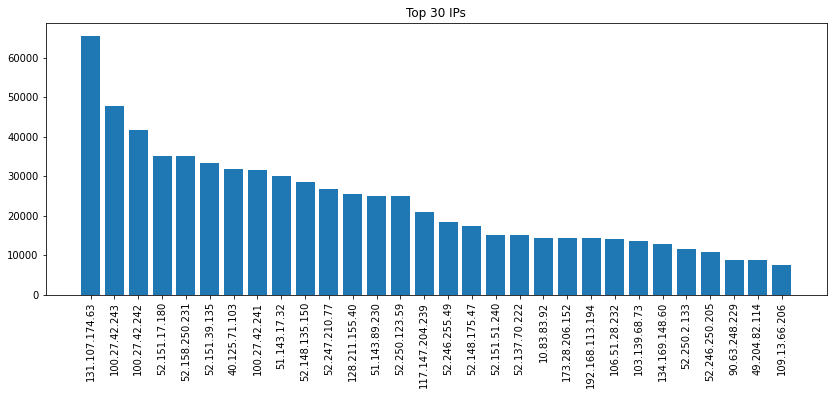

In [65]:
from operator import itemgetter 

ip_bins = {ip: 0 for ip in df['ip']}
for ip in df['ip']:
    ip_bins[ip] += 1
    
# get top 30 IPs
ip_bins = dict(sorted(ip_bins.items(), key = itemgetter(1), reverse = True)[:30])
print(ip_bins)
plt.gcf().set_size_inches(14, 5)
plt.bar(ip_bins.keys(), ip_bins.values())
plt.xticks(rotation=90)
plt.yscale('linear')
plt.title("Top 30 IPs")
plt.show()

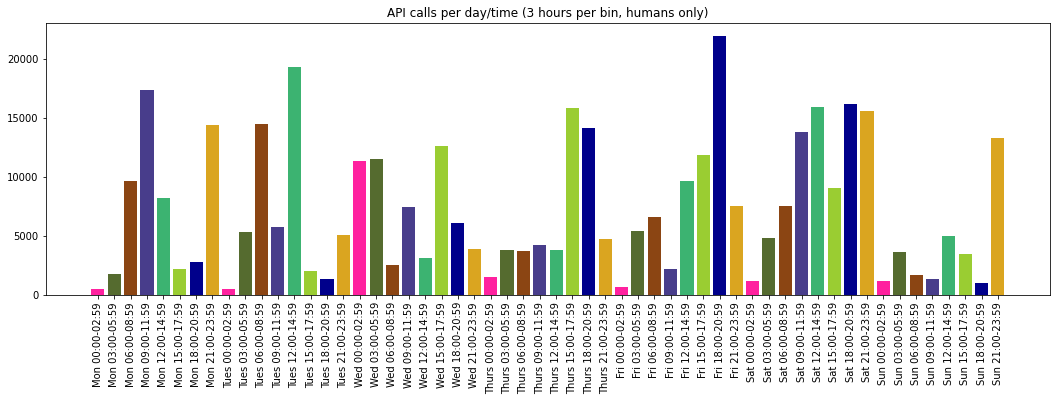

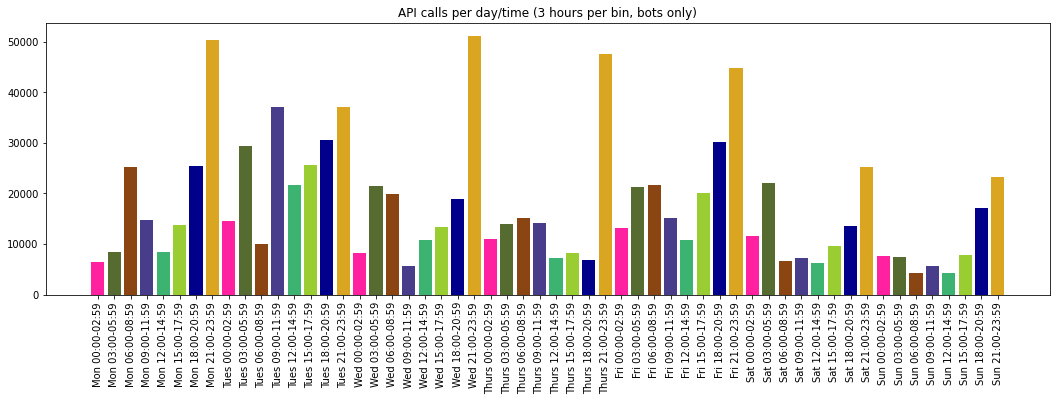

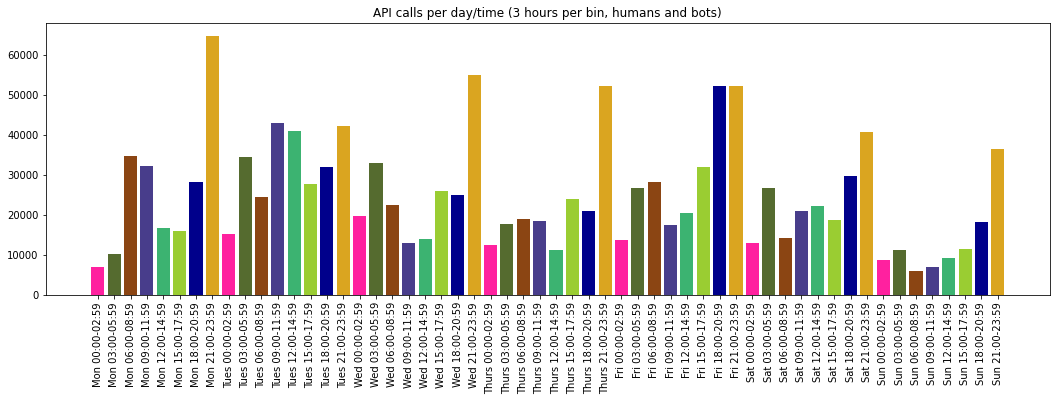

In [66]:
from datetime import datetime
from math import ceil

hours_per_bin = 3 # number of hours to group together in a single bin

for mode in ['humans only', 'bots only', 'humans and bots']:
    times = [{hour: 0 for hour in range(24)} for i in range(7)]
    for str_time in (df_onlybots['time'] if mode == 'bots only' else df_nobots['time'] if mode == 'humans only' else df['time']):
        date_time = datetime.strptime(str_time.split('"')[0].strip(), "[%d/%b/%Y:%H:%M:%S %z]")
        hour = date_time.hour
        while (hour % hours_per_bin != 0) and (hour > 0) and (hour < 23): hour += 1
        if hour == 23: hour -= (hours_per_bin - 1)
        times[date_time.weekday()][hour] += 1

    days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    xs = [str(day) + " " + ("0" if hour < 10 else "") + (str(hour) + ":00-" +
        ("0" if hour+hours_per_bin-1 < 10 else "") +\
        str(hour+hours_per_bin-1 if hour+hours_per_bin-1 < 23 else 23) +\
        ":59") for day in days for hour in range(24)]
    ys = [val for time in times for key, val in time.items()]

    # remove 0 values from bar graph
    xs = [x for index, x in enumerate(xs) if ys[index] > 0]
    ys = [y for y in ys if y > 0]

    # generated by https://mokole.com/palette.html
    random_colors = ['#ff219f', '#556b2f', '#8b4513', '#483d8b', '#3cb371', '#9acd32',
              '#00008b', '#daa520', '#8b008b', '#ff4500', '#ffff00', '#00ff00',
              '#00ff7f', '#dc143c', '#00ffff', '#0000ff', '#ff00ff', '#1e90ff',
              '#db7093', '#eee8aa', '#add8e6', '#ff1493', '#ffa07a', '#ee82ee']
    colors = [random_colors[x] for i in range(7) for x in range(0, ceil(24/hours_per_bin))]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.figure.set_size_inches(18, 5)
    ax.bar(xs, ys, color=colors)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    plt.title("API calls per day/time (" + str(hours_per_bin) + " hours per bin, " + str(mode) + ")")
    plt.show()

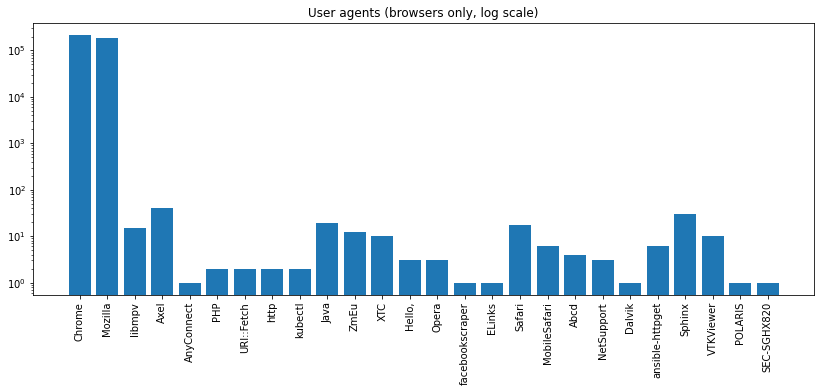

{'Abcd': 4,
 'AnyConnect': 1,
 'Axel': 40,
 'Chrome': 210657,
 'Dalvik': 1,
 'ELinks': 1,
 'Hello,': 3,
 'Java': 19,
 'MobileSafari': 6,
 'Mozilla': 185785,
 'NetSupport': 3,
 'Opera': 3,
 'PHP': 2,
 'POLARIS': 1,
 'SEC-SGHX820': 1,
 'Safari': 17,
 'Sphinx': 30,
 'URI::Fetch': 2,
 'VTKViewer': 10,
 'XTC': 10,
 'ZmEu': 12,
 'ansible-httpget': 6,
 'facebookscraper': 1,
 'http': 2,
 'kubectl': 2,
 'libmpv': 15}


In [67]:
uas = {}
for ua in df_nobots['user_agent']:
    if ua is None or 'Content-Type: text/plain' in ua or '"NetSystemsResearch studies the availability ' in ua:
        continue
    if 'Chrome' in ua:
        ua = 'Chrome'
    ua = ua.replace('"', '').split('/')[0].split(' ')[0].split('%')[0]
    while '\\x' in ua: # eliminate extra characters caused by erroneous request
        i = ua.index('\\x')
        ua = ua[0:i] + ua[i+4:len(ua)]
    uas[ua] = uas[ua] + 1 if ua in uas else 1
plt.gcf().set_size_inches(14, 5)
plt.xticks(rotation=90)
plt.yscale('log')
plt.bar(uas.keys(), uas.values())
plt.title("User agents (browsers only, log scale)")
plt.show()
pprint(uas)

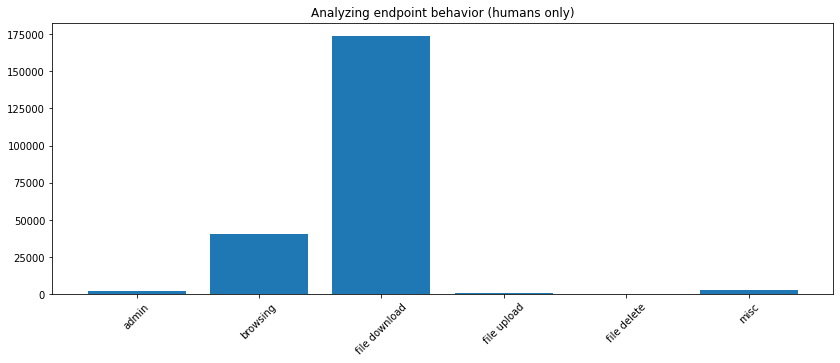

{'admin': 2057, 'browsing': 40932, 'file download': 173943, 'file upload': 1100, 'file delete': 0, 'misc': 3082}


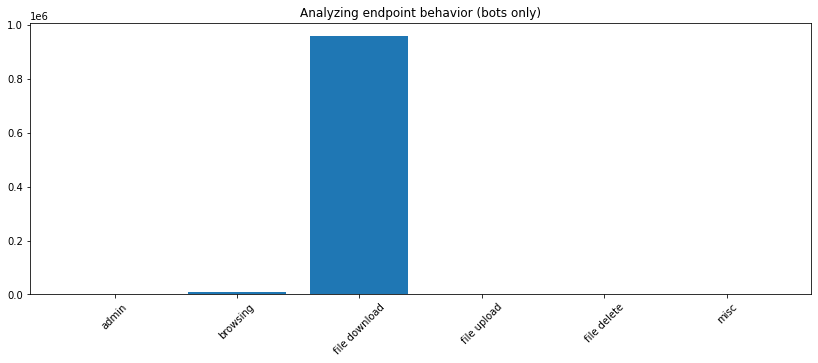

{'admin': 178, 'browsing': 8855, 'file download': 960065, 'file upload': 2933, 'file delete': 0, 'misc': 44}


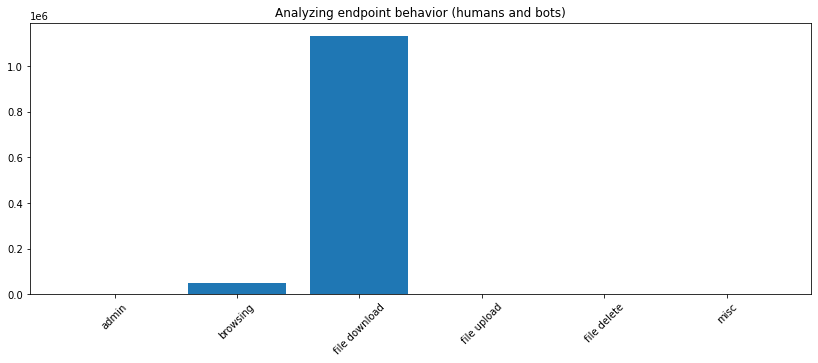

{'admin': 2235, 'browsing': 49787, 'file download': 1134008, 'file upload': 4033, 'file delete': 0, 'misc': 3126}


In [73]:
api_groups = {}
with open('api_groups.json', 'r') as json_file:
    api_groups = json.load(json_file)

for mode in ['humans only', 'bots only', 'humans and bots']:
    group_bins = {group: 0 for group in ['admin', 'browsing', 'file download', 'file upload', 'file delete', 'misc']}
    for request in (df['request'] if mode == 'humans and bots' else\
                    df_onlybots['request'] if mode == 'bots only' else df_nobots['request']):
        try:
            req_type = request.split(' ')[0][1:]
            endpoint = re.search("(?P<url>/[^\s]+)", request).group("url").replace('/api/v1/', '')
        except:
            continue

        endpoint = parse_endpoint(endpoint)
        key = ' '.join([req_type, endpoint])
        
        if key in api_groups:
            group_bins[api_groups[key]['group']] += 1
    plt.title('Analyzing endpoint behavior (' + str(mode) + ')')
    plt.gcf().set_size_inches(14, 5)
    plt.bar(group_bins.keys(), group_bins.values())
    plt.xticks(rotation=45)
    plt.show()
    print(group_bins)

This bar graph attempts to illustrate the most common way people use DKC. Based on the graph, it seems people mostly use DKC as a simple file store without using some of the more advanced features. See api_groups.json for which endpoints are in each bin.